# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.433622838830805 -3.0178012443561286
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size, lstm_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # GRU: Gated Recurrent Units
    gru = tf.nn.rnn_cell.GRUCell(lstm_size) # hidden size
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    g_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    d_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    return states, actions, targetQs, cell, g_initial_state, d_initial_state

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# MLP & Conv
# # Generator/Controller: Generating/prediting the actions
# def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('generator', reuse=reuse):
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=states, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=action_size)        
#         #predictions = tf.nn.softmax(logits)

#         # return actions logits
#         return logits

In [17]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [18]:
# MLP & Conv
# # Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
# def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('discriminator', reuse=reuse):
#         # Fusion/merge states and actions/ SA/ SM
#         x_fused = tf.concat(axis=1, values=[states, actions])
        
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=1)        
#         #predictions = tf.nn.softmax(logits)

#         # return rewards logits
#         return logits

In [19]:
# RNN generator or sequence generator
def discriminator(states, actions, initial_state, cell, lstm_size, reuse=False): 
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        inputs = tf.layers.dense(inputs=x_fused, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=1)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [28]:
def model_loss(action_size, hidden_size, states, actions, targetQs,
               cell, g_initial_state, d_initial_state):
    # G/Actor
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_logits, g_final_state = generator(states=states, num_classes=action_size, 
                                              cell=cell, initial_state=g_initial_state, lstm_size=hidden_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs)
    
    # D/Critic
    #Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    Qs_logits, d_final_state = discriminator(states=states, actions=actions_logits, 
                                             cell=cell, initial_state=d_initial_state, lstm_size=hidden_size)
    d_lossQ = tf.reduce_mean(tf.square(tf.reshape(Qs_logits, [-1]) - targetQs))
    d_lossQ_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                          labels=tf.nn.sigmoid(targetQs)))
    d_loss = d_lossQ_sigm# + d_lossQ

    return actions_logits, Qs_logits, g_final_state, d_final_state, g_loss, d_loss, d_lossQ, d_lossQ_sigm

In [29]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize RNN
    # g_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(g_loss, g_vars), clip_norm=5) # usually around 1-5
    # d_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(d_loss, d_vars), clip_norm=5) # usually around 1-5
    g_grads=tf.gradients(g_loss, g_vars)
    d_grads=tf.gradients(d_loss, d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(g_grads, g_vars))
    d_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(d_grads, d_vars))
    
    # # Optimize MLP & CNN
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    #     g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    #     d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [30]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, cell, self.g_initial_state, self.d_initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_final_state, self.d_final_state, self.g_loss, self.d_loss, self.d_lossQ, self.d_lossQ_sigm = model_loss(
            action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, cell=cell, targetQs=self.targetQs,
            g_initial_state=self.g_initial_state, d_initial_state=self.d_initial_state)
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [31]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [32]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [33]:
# Training parameters
# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 64                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

In [34]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 1)


In [35]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

In [36]:
memory.buffer[0]

[array([ 0.00585929,  0.01409051, -0.00414137,  0.03539938]),
 1,
 array([ 0.0061411 ,  0.20927161, -0.00343339, -0.25858732]),
 1.0,
 0.0]

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
from collections import deque
episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossQ_list, d_lossQsigm_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        state = env.reset() # env first state
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)

        # Training steps/batches
        while True:
            # Testing/inference
            action_logits, g_final_state, d_final_state = sess.run(
                fetches=[model.actions_logits, model.g_final_state, model.d_final_state], 
                feed_dict={model.states: np.reshape(state, [1, -1]),
                           model.g_initial_state: g_initial_state,
                           model.d_initial_state: d_initial_state})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([g_initial_state, g_final_state,
                                  d_initial_state, d_final_state])
            total_reward += reward
            g_initial_state = g_final_state
            d_initial_state = d_final_state
            state = next_state
            
            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            g_initial_states = np.array([each[0] for each in rnn_states])
            g_final_states = np.array([each[1] for each in rnn_states])
            d_initial_states = np.array([each[2] for each in rnn_states])
            d_final_states = np.array([each[3] for each in rnn_states])
            nextQs_logits = sess.run(fetches = model.Qs_logits,
                                     feed_dict = {model.states: next_states, 
                                                  model.g_initial_state: g_final_states[0].reshape([1, -1]),
                                                  model.d_initial_state: d_final_states[0].reshape([1, -1])})
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # exploit
            targetQs = rewards + (0.99 * nextQs)
            g_loss, d_loss, d_lossQ, d_lossQsigm, _, _ = sess.run(
                fetches=[model.g_loss, model.d_loss, 
                         model.d_lossQ, model.d_lossQ_sigm,
                         model.g_opt, model.d_opt], 
                feed_dict = {model.states: states, model.actions: actions,
                             model.targetQs: targetQs,
                             model.g_initial_state: g_initial_states[0].reshape([1, -1]),
                             model.d_initial_state: d_initial_states[0].reshape([1, -1])})

            if done is True:
                break

        # Episode total reward and success rate/prob
        episode_reward.append(total_reward) # stopping criteria
        rate = total_reward/ 500 # success is 500 points: 0-1
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossQ:{:.4f}'.format(d_lossQ),
              'dlossQsigm:{:.4f}'.format(d_lossQsigm))
        # Ploting out
        rewards_list.append([ep, np.mean(episode_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossQ_list.append([ep, d_lossQ])
        d_lossQsigm_list.append([ep, d_lossQsigm])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-seq2.ckpt')

Episode:0 meanR:27.0000 rate:0.0540 gloss:0.9811 dloss:0.5451 dlossQ:1.0034 dlossQsigm:0.5451
Episode:1 meanR:27.0000 rate:0.0540 gloss:1.3848 dloss:0.3311 dlossQ:1.0244 dlossQsigm:0.3311
Episode:2 meanR:25.3333 rate:0.0440 gloss:1.2722 dloss:0.2388 dlossQ:1.1668 dlossQsigm:0.2388
Episode:3 meanR:25.2500 rate:0.0500 gloss:1.8530 dloss:0.1231 dlossQ:1.4945 dlossQsigm:0.1231
Episode:4 meanR:27.2000 rate:0.0700 gloss:1.1754 dloss:0.0970 dlossQ:1.5023 dlossQsigm:0.0970
Episode:5 meanR:26.0000 rate:0.0400 gloss:0.9583 dloss:0.0941 dlossQ:1.6436 dlossQsigm:0.0941
Episode:6 meanR:26.0000 rate:0.0520 gloss:0.4913 dloss:0.0922 dlossQ:1.7002 dlossQsigm:0.0922
Episode:7 meanR:26.3750 rate:0.0580 gloss:0.2979 dloss:0.0951 dlossQ:1.5426 dlossQsigm:0.0951
Episode:8 meanR:25.5556 rate:0.0380 gloss:0.2414 dloss:0.0945 dlossQ:1.4984 dlossQsigm:0.0945
Episode:9 meanR:25.3000 rate:0.0460 gloss:0.1136 dloss:0.0972 dlossQ:1.4164 dlossQsigm:0.0972
Episode:10 meanR:24.8182 rate:0.0400 gloss:0.0320 dloss:0.11

Episode:87 meanR:22.7500 rate:0.0600 gloss:0.0022 dloss:0.0837 dlossQ:0.7585 dlossQsigm:0.0837
Episode:88 meanR:22.6742 rate:0.0320 gloss:0.0008 dloss:0.1230 dlossQ:0.5419 dlossQsigm:0.1230
Episode:89 meanR:22.6778 rate:0.0460 gloss:0.0006 dloss:0.0972 dlossQ:0.4989 dlossQsigm:0.0972
Episode:90 meanR:22.6923 rate:0.0480 gloss:0.0006 dloss:0.1252 dlossQ:0.4061 dlossQsigm:0.1252
Episode:91 meanR:22.6304 rate:0.0340 gloss:0.0077 dloss:0.1105 dlossQ:0.7277 dlossQsigm:0.1105
Episode:92 meanR:22.6344 rate:0.0460 gloss:0.0132 dloss:0.1172 dlossQ:0.7260 dlossQsigm:0.1172
Episode:93 meanR:22.5638 rate:0.0320 gloss:0.0003 dloss:0.1251 dlossQ:0.4876 dlossQsigm:0.1251
Episode:94 meanR:22.4947 rate:0.0320 gloss:0.0002 dloss:0.1281 dlossQ:0.5158 dlossQsigm:0.1281
Episode:95 meanR:22.4583 rate:0.0380 gloss:0.0001 dloss:0.1056 dlossQ:0.5789 dlossQsigm:0.1056
Episode:96 meanR:22.4639 rate:0.0460 gloss:0.0001 dloss:0.1350 dlossQ:0.7699 dlossQsigm:0.1350
Episode:97 meanR:22.5714 rate:0.0660 gloss:0.0036 

Episode:173 meanR:21.1800 rate:0.0500 gloss:0.0025 dloss:0.0587 dlossQ:0.9180 dlossQsigm:0.0587
Episode:174 meanR:21.0800 rate:0.0340 gloss:0.0008 dloss:0.1006 dlossQ:0.7618 dlossQsigm:0.1006
Episode:175 meanR:21.1800 rate:0.0560 gloss:0.0011 dloss:0.0922 dlossQ:0.6967 dlossQsigm:0.0922
Episode:176 meanR:21.1700 rate:0.0420 gloss:0.0002 dloss:0.0817 dlossQ:0.7354 dlossQsigm:0.0817
Episode:177 meanR:21.0700 rate:0.0340 gloss:0.0000 dloss:0.0969 dlossQ:1.0206 dlossQsigm:0.0969
Episode:178 meanR:21.0800 rate:0.0440 gloss:0.0001 dloss:0.1374 dlossQ:0.8478 dlossQsigm:0.1374
Episode:179 meanR:21.1200 rate:0.0440 gloss:0.0001 dloss:0.1324 dlossQ:1.0168 dlossQsigm:0.1324
Episode:180 meanR:21.2300 rate:0.0540 gloss:0.0002 dloss:0.0566 dlossQ:1.1701 dlossQsigm:0.0566
Episode:181 meanR:21.2600 rate:0.0380 gloss:0.0001 dloss:0.0761 dlossQ:0.5993 dlossQsigm:0.0761
Episode:182 meanR:21.3200 rate:0.0440 gloss:0.0000 dloss:0.1016 dlossQ:0.4761 dlossQsigm:0.1016
Episode:183 meanR:21.3500 rate:0.0420 gl

Episode:259 meanR:21.8100 rate:0.0540 gloss:0.0000 dloss:0.1165 dlossQ:0.7748 dlossQsigm:0.1165
Episode:260 meanR:21.8000 rate:0.0380 gloss:0.0001 dloss:0.0943 dlossQ:0.7398 dlossQsigm:0.0943
Episode:261 meanR:21.8400 rate:0.0380 gloss:0.0006 dloss:0.0881 dlossQ:0.8018 dlossQsigm:0.0881
Episode:262 meanR:21.8300 rate:0.0380 gloss:0.0000 dloss:0.1056 dlossQ:0.4798 dlossQsigm:0.1056
Episode:263 meanR:21.9000 rate:0.0460 gloss:0.0000 dloss:0.1174 dlossQ:0.6034 dlossQsigm:0.1174
Episode:264 meanR:21.9600 rate:0.0460 gloss:0.0000 dloss:0.0958 dlossQ:0.7318 dlossQsigm:0.0958
Episode:265 meanR:21.9000 rate:0.0380 gloss:0.0009 dloss:0.0977 dlossQ:0.8324 dlossQsigm:0.0977
Episode:266 meanR:21.9700 rate:0.0500 gloss:0.0000 dloss:0.0881 dlossQ:0.8727 dlossQsigm:0.0881
Episode:267 meanR:21.9600 rate:0.0300 gloss:0.0000 dloss:0.1230 dlossQ:0.7831 dlossQsigm:0.1230
Episode:268 meanR:21.9300 rate:0.0300 gloss:0.0000 dloss:0.1122 dlossQ:0.7669 dlossQsigm:0.1122
Episode:269 meanR:21.8500 rate:0.0300 gl

Episode:345 meanR:20.9900 rate:0.0320 gloss:0.0000 dloss:0.1193 dlossQ:0.6115 dlossQsigm:0.1193
Episode:346 meanR:21.0200 rate:0.0500 gloss:0.0018 dloss:0.1077 dlossQ:0.9836 dlossQsigm:0.1077
Episode:347 meanR:20.9300 rate:0.0420 gloss:0.0000 dloss:0.1232 dlossQ:0.9829 dlossQsigm:0.1232
Episode:348 meanR:20.9400 rate:0.0400 gloss:0.0000 dloss:0.0969 dlossQ:0.7509 dlossQsigm:0.0969
Episode:349 meanR:20.9500 rate:0.0420 gloss:0.0000 dloss:0.0985 dlossQ:0.5779 dlossQsigm:0.0985
Episode:350 meanR:20.9400 rate:0.0380 gloss:0.0000 dloss:0.1125 dlossQ:0.5663 dlossQsigm:0.1125
Episode:351 meanR:20.9500 rate:0.0340 gloss:0.0000 dloss:0.1017 dlossQ:0.3435 dlossQsigm:0.1017
Episode:352 meanR:21.0000 rate:0.0520 gloss:0.0012 dloss:0.0796 dlossQ:0.7137 dlossQsigm:0.0796
Episode:353 meanR:21.0500 rate:0.0500 gloss:0.0001 dloss:0.0666 dlossQ:0.8024 dlossQsigm:0.0666
Episode:354 meanR:21.0700 rate:0.0380 gloss:0.0004 dloss:0.0925 dlossQ:0.9959 dlossQsigm:0.0925
Episode:355 meanR:21.2000 rate:0.0580 gl

Episode:431 meanR:20.7400 rate:0.0580 gloss:0.0000 dloss:0.0733 dlossQ:0.4632 dlossQsigm:0.0733
Episode:432 meanR:20.7200 rate:0.0440 gloss:0.0000 dloss:0.0923 dlossQ:0.3873 dlossQsigm:0.0923
Episode:433 meanR:20.7700 rate:0.0500 gloss:0.0000 dloss:0.0765 dlossQ:0.2610 dlossQsigm:0.0765
Episode:434 meanR:20.8200 rate:0.0460 gloss:0.0000 dloss:0.0809 dlossQ:0.2941 dlossQsigm:0.0809
Episode:435 meanR:20.8100 rate:0.0380 gloss:0.0000 dloss:0.1090 dlossQ:0.3581 dlossQsigm:0.1090
Episode:436 meanR:20.7900 rate:0.0340 gloss:0.0000 dloss:0.1440 dlossQ:0.1456 dlossQsigm:0.1440
Episode:437 meanR:20.7400 rate:0.0440 gloss:0.0000 dloss:0.1332 dlossQ:0.0905 dlossQsigm:0.1332
Episode:438 meanR:20.7000 rate:0.0300 gloss:0.0000 dloss:0.1187 dlossQ:0.1505 dlossQsigm:0.1187
Episode:439 meanR:20.7200 rate:0.0400 gloss:0.0000 dloss:0.1156 dlossQ:0.1417 dlossQsigm:0.1156
Episode:440 meanR:20.7400 rate:0.0420 gloss:0.0001 dloss:0.1005 dlossQ:0.1604 dlossQsigm:0.1005
Episode:441 meanR:20.6900 rate:0.0360 gl

Episode:517 meanR:20.4000 rate:0.0320 gloss:0.0000 dloss:0.1066 dlossQ:0.2293 dlossQsigm:0.1066
Episode:518 meanR:20.3800 rate:0.0300 gloss:0.0000 dloss:0.1024 dlossQ:0.1942 dlossQsigm:0.1024
Episode:519 meanR:20.3400 rate:0.0280 gloss:0.0000 dloss:0.1040 dlossQ:0.1763 dlossQsigm:0.1040
Episode:520 meanR:20.2900 rate:0.0320 gloss:0.0000 dloss:0.1270 dlossQ:0.0442 dlossQsigm:0.1270
Episode:521 meanR:20.3300 rate:0.0380 gloss:0.0000 dloss:0.0963 dlossQ:0.2157 dlossQsigm:0.0963
Episode:522 meanR:20.4500 rate:0.0600 gloss:0.0000 dloss:0.0752 dlossQ:0.3677 dlossQsigm:0.0752
Episode:523 meanR:20.4400 rate:0.0360 gloss:0.0000 dloss:0.0778 dlossQ:0.2860 dlossQsigm:0.0778
Episode:524 meanR:20.4100 rate:0.0340 gloss:0.0000 dloss:0.0779 dlossQ:0.4838 dlossQsigm:0.0779
Episode:525 meanR:20.4000 rate:0.0320 gloss:0.0000 dloss:0.0993 dlossQ:0.1063 dlossQsigm:0.0993
Episode:526 meanR:20.3800 rate:0.0320 gloss:0.0000 dloss:0.0973 dlossQ:0.1373 dlossQsigm:0.0973
Episode:527 meanR:20.4500 rate:0.0500 gl

Episode:603 meanR:20.3400 rate:0.0540 gloss:0.0000 dloss:0.0764 dlossQ:0.4570 dlossQsigm:0.0764
Episode:604 meanR:20.3500 rate:0.0520 gloss:0.0000 dloss:0.0861 dlossQ:0.3286 dlossQsigm:0.0861
Episode:605 meanR:20.3500 rate:0.0480 gloss:0.0000 dloss:0.0846 dlossQ:0.3050 dlossQsigm:0.0846
Episode:606 meanR:20.3000 rate:0.0400 gloss:0.0000 dloss:0.0738 dlossQ:0.3052 dlossQsigm:0.0738
Episode:607 meanR:20.3200 rate:0.0420 gloss:0.0000 dloss:0.0656 dlossQ:0.4049 dlossQsigm:0.0656
Episode:608 meanR:20.3300 rate:0.0340 gloss:0.0000 dloss:0.0911 dlossQ:0.1033 dlossQsigm:0.0911
Episode:609 meanR:20.3100 rate:0.0320 gloss:0.0000 dloss:0.1023 dlossQ:0.1290 dlossQsigm:0.1023
Episode:610 meanR:20.3200 rate:0.0380 gloss:0.0000 dloss:0.1146 dlossQ:0.1514 dlossQsigm:0.1146
Episode:611 meanR:20.3300 rate:0.0340 gloss:0.0000 dloss:0.1118 dlossQ:0.1444 dlossQsigm:0.1118
Episode:612 meanR:20.3600 rate:0.0460 gloss:0.0000 dloss:0.1086 dlossQ:0.1993 dlossQsigm:0.1086
Episode:613 meanR:20.4000 rate:0.0500 gl

Episode:689 meanR:20.2200 rate:0.0340 gloss:0.0000 dloss:0.1104 dlossQ:0.2288 dlossQsigm:0.1104
Episode:690 meanR:20.2900 rate:0.0480 gloss:0.0000 dloss:0.1241 dlossQ:0.2092 dlossQsigm:0.1241
Episode:691 meanR:20.2600 rate:0.0340 gloss:0.0000 dloss:0.1256 dlossQ:0.1988 dlossQsigm:0.1256
Episode:692 meanR:20.2600 rate:0.0320 gloss:0.0000 dloss:0.1405 dlossQ:0.1919 dlossQsigm:0.1405
Episode:693 meanR:20.2200 rate:0.0400 gloss:0.0000 dloss:0.1100 dlossQ:0.2208 dlossQsigm:0.1100
Episode:694 meanR:20.2100 rate:0.0500 gloss:0.0000 dloss:0.1151 dlossQ:0.3769 dlossQsigm:0.1151
Episode:695 meanR:20.2100 rate:0.0340 gloss:0.0000 dloss:0.0831 dlossQ:0.3217 dlossQsigm:0.0831
Episode:696 meanR:20.1400 rate:0.0340 gloss:0.0000 dloss:0.1080 dlossQ:0.4827 dlossQsigm:0.1080
Episode:697 meanR:20.2100 rate:0.0480 gloss:0.0000 dloss:0.1195 dlossQ:0.3020 dlossQsigm:0.1195
Episode:698 meanR:20.2100 rate:0.0380 gloss:0.0000 dloss:0.1176 dlossQ:0.2971 dlossQsigm:0.1176
Episode:699 meanR:20.3100 rate:0.0540 gl

Episode:775 meanR:20.9100 rate:0.0460 gloss:0.0000 dloss:0.0790 dlossQ:0.8008 dlossQsigm:0.0790
Episode:776 meanR:20.9900 rate:0.0500 gloss:0.0000 dloss:0.0715 dlossQ:0.9226 dlossQsigm:0.0715
Episode:777 meanR:20.9900 rate:0.0340 gloss:0.0000 dloss:0.1090 dlossQ:0.7881 dlossQsigm:0.1090
Episode:778 meanR:21.0700 rate:0.0500 gloss:0.0000 dloss:0.0944 dlossQ:0.7097 dlossQsigm:0.0944
Episode:779 meanR:20.9700 rate:0.0400 gloss:0.0000 dloss:0.0990 dlossQ:0.4598 dlossQsigm:0.0990
Episode:780 meanR:20.9200 rate:0.0400 gloss:0.0000 dloss:0.0773 dlossQ:0.6011 dlossQsigm:0.0773
Episode:781 meanR:20.9000 rate:0.0300 gloss:0.0000 dloss:0.1042 dlossQ:0.2641 dlossQsigm:0.1042
Episode:782 meanR:20.8800 rate:0.0340 gloss:0.0000 dloss:0.1148 dlossQ:0.3196 dlossQsigm:0.1148
Episode:783 meanR:20.8700 rate:0.0320 gloss:0.0000 dloss:0.1226 dlossQ:0.3662 dlossQsigm:0.1226
Episode:784 meanR:20.8700 rate:0.0320 gloss:0.0000 dloss:0.1169 dlossQ:0.4638 dlossQsigm:0.1169
Episode:785 meanR:20.8500 rate:0.0320 gl

Episode:861 meanR:20.4300 rate:0.0540 gloss:0.0000 dloss:0.0707 dlossQ:0.4863 dlossQsigm:0.0707
Episode:862 meanR:20.3900 rate:0.0500 gloss:0.0000 dloss:0.0845 dlossQ:0.3617 dlossQsigm:0.0845
Episode:863 meanR:20.4000 rate:0.0340 gloss:0.0000 dloss:0.0942 dlossQ:0.3380 dlossQsigm:0.0942
Episode:864 meanR:20.4000 rate:0.0420 gloss:0.0000 dloss:0.1106 dlossQ:0.1826 dlossQsigm:0.1106
Episode:865 meanR:20.3500 rate:0.0300 gloss:0.0000 dloss:0.1186 dlossQ:0.1946 dlossQsigm:0.1186
Episode:866 meanR:20.4500 rate:0.0620 gloss:0.0000 dloss:0.0958 dlossQ:0.4342 dlossQsigm:0.0958
Episode:867 meanR:20.5000 rate:0.0420 gloss:0.0000 dloss:0.0962 dlossQ:0.3725 dlossQsigm:0.0962
Episode:868 meanR:20.4000 rate:0.0380 gloss:0.0000 dloss:0.0929 dlossQ:0.4559 dlossQsigm:0.0929
Episode:869 meanR:20.3900 rate:0.0320 gloss:0.0000 dloss:0.1074 dlossQ:0.2649 dlossQsigm:0.1074
Episode:870 meanR:20.3300 rate:0.0380 gloss:0.0000 dloss:0.0988 dlossQ:0.3080 dlossQsigm:0.0988
Episode:871 meanR:20.2500 rate:0.0400 gl

Episode:947 meanR:20.3600 rate:0.0340 gloss:0.0000 dloss:0.1027 dlossQ:0.2420 dlossQsigm:0.1027
Episode:948 meanR:20.3400 rate:0.0500 gloss:0.0000 dloss:0.0997 dlossQ:0.1986 dlossQsigm:0.0997
Episode:949 meanR:20.3100 rate:0.0320 gloss:0.0000 dloss:0.1097 dlossQ:0.1528 dlossQsigm:0.1097
Episode:950 meanR:20.3200 rate:0.0320 gloss:0.0000 dloss:0.1010 dlossQ:0.2067 dlossQsigm:0.1010
Episode:951 meanR:20.3100 rate:0.0300 gloss:0.0000 dloss:0.0876 dlossQ:0.2231 dlossQsigm:0.0876
Episode:952 meanR:20.3100 rate:0.0340 gloss:0.0000 dloss:0.0918 dlossQ:0.2417 dlossQsigm:0.0918
Episode:953 meanR:20.2900 rate:0.0460 gloss:0.0000 dloss:0.0986 dlossQ:0.1338 dlossQsigm:0.0986
Episode:954 meanR:20.3000 rate:0.0420 gloss:0.0000 dloss:0.0980 dlossQ:0.1530 dlossQsigm:0.0980
Episode:955 meanR:20.3300 rate:0.0520 gloss:0.0000 dloss:0.0796 dlossQ:0.2237 dlossQsigm:0.0796
Episode:956 meanR:20.4500 rate:0.0520 gloss:0.0000 dloss:0.0772 dlossQ:0.3769 dlossQsigm:0.0772
Episode:957 meanR:20.5500 rate:0.0540 gl

Episode:1033 meanR:20.1800 rate:0.0480 gloss:0.0000 dloss:0.0799 dlossQ:0.3587 dlossQsigm:0.0799
Episode:1034 meanR:20.3000 rate:0.0540 gloss:0.0000 dloss:0.0766 dlossQ:0.3377 dlossQsigm:0.0766
Episode:1035 meanR:20.2000 rate:0.0320 gloss:0.0000 dloss:0.0723 dlossQ:0.3341 dlossQsigm:0.0723
Episode:1036 meanR:20.2500 rate:0.0520 gloss:0.0000 dloss:0.0704 dlossQ:0.3819 dlossQsigm:0.0704
Episode:1037 meanR:20.2500 rate:0.0320 gloss:0.0000 dloss:0.0933 dlossQ:0.2129 dlossQsigm:0.0933
Episode:1038 meanR:20.3400 rate:0.0560 gloss:0.0000 dloss:0.0687 dlossQ:0.4958 dlossQsigm:0.0687
Episode:1039 meanR:20.3600 rate:0.0460 gloss:0.0000 dloss:0.0840 dlossQ:0.5906 dlossQsigm:0.0840
Episode:1040 meanR:20.3000 rate:0.0400 gloss:0.0000 dloss:0.0883 dlossQ:0.2344 dlossQsigm:0.0883
Episode:1041 meanR:20.3100 rate:0.0460 gloss:0.0000 dloss:0.0761 dlossQ:0.4413 dlossQsigm:0.0761
Episode:1042 meanR:20.2600 rate:0.0340 gloss:0.0000 dloss:0.1083 dlossQ:0.1775 dlossQsigm:0.1083
Episode:1043 meanR:20.2500 rat

Episode:1118 meanR:20.3100 rate:0.0300 gloss:0.0000 dloss:0.1040 dlossQ:0.2456 dlossQsigm:0.1040
Episode:1119 meanR:20.2900 rate:0.0280 gloss:0.0000 dloss:0.0943 dlossQ:0.3468 dlossQsigm:0.0943
Episode:1120 meanR:20.4000 rate:0.0580 gloss:0.0000 dloss:0.0864 dlossQ:0.3951 dlossQsigm:0.0864
Episode:1121 meanR:20.4800 rate:0.0540 gloss:0.0000 dloss:0.0748 dlossQ:0.4221 dlossQsigm:0.0748
Episode:1122 meanR:20.5100 rate:0.0480 gloss:0.0000 dloss:0.0800 dlossQ:0.2966 dlossQsigm:0.0800
Episode:1123 meanR:20.6200 rate:0.0540 gloss:0.0000 dloss:0.0699 dlossQ:0.3719 dlossQsigm:0.0699
Episode:1124 meanR:20.6300 rate:0.0380 gloss:0.0000 dloss:0.0663 dlossQ:0.3679 dlossQsigm:0.0663
Episode:1125 meanR:20.7100 rate:0.0460 gloss:0.0000 dloss:0.0778 dlossQ:0.4648 dlossQsigm:0.0778
Episode:1126 meanR:20.6800 rate:0.0340 gloss:0.0000 dloss:0.0861 dlossQ:0.2945 dlossQsigm:0.0861
Episode:1127 meanR:20.8100 rate:0.0620 gloss:0.0000 dloss:0.0667 dlossQ:0.2546 dlossQsigm:0.0667
Episode:1128 meanR:20.8200 rat

Episode:1203 meanR:19.9900 rate:0.0400 gloss:0.0000 dloss:0.0893 dlossQ:0.1105 dlossQsigm:0.0893
Episode:1204 meanR:19.9900 rate:0.0380 gloss:0.0000 dloss:0.0920 dlossQ:0.1189 dlossQsigm:0.0920
Episode:1205 meanR:19.9700 rate:0.0300 gloss:0.0000 dloss:0.0901 dlossQ:0.0987 dlossQsigm:0.0901
Episode:1206 meanR:19.9600 rate:0.0300 gloss:0.0000 dloss:0.0962 dlossQ:0.1992 dlossQsigm:0.0962
Episode:1207 meanR:19.8700 rate:0.0320 gloss:0.0000 dloss:0.0913 dlossQ:0.2443 dlossQsigm:0.0913
Episode:1208 meanR:19.9700 rate:0.0580 gloss:0.0000 dloss:0.0961 dlossQ:0.2114 dlossQsigm:0.0961
Episode:1209 meanR:20.0300 rate:0.0460 gloss:0.0000 dloss:0.0760 dlossQ:0.2274 dlossQsigm:0.0760
Episode:1210 meanR:20.0500 rate:0.0500 gloss:0.0000 dloss:0.0779 dlossQ:0.2716 dlossQsigm:0.0779
Episode:1211 meanR:20.0700 rate:0.0460 gloss:0.0000 dloss:0.0810 dlossQ:0.2712 dlossQsigm:0.0810
Episode:1212 meanR:20.0400 rate:0.0460 gloss:0.0000 dloss:0.0787 dlossQ:0.2326 dlossQsigm:0.0787
Episode:1213 meanR:20.0200 rat

Episode:1288 meanR:20.4600 rate:0.0400 gloss:0.0000 dloss:0.0958 dlossQ:0.2278 dlossQsigm:0.0958
Episode:1289 meanR:20.4900 rate:0.0460 gloss:0.0000 dloss:0.0763 dlossQ:0.4284 dlossQsigm:0.0763
Episode:1290 meanR:20.5200 rate:0.0420 gloss:0.0000 dloss:0.0778 dlossQ:0.3221 dlossQsigm:0.0778
Episode:1291 meanR:20.5400 rate:0.0440 gloss:0.0000 dloss:0.0757 dlossQ:0.3319 dlossQsigm:0.0757
Episode:1292 meanR:20.6400 rate:0.0500 gloss:0.0000 dloss:0.0666 dlossQ:0.3229 dlossQsigm:0.0666
Episode:1293 meanR:20.7900 rate:0.0600 gloss:0.0000 dloss:0.0707 dlossQ:0.4685 dlossQsigm:0.0707
Episode:1294 meanR:20.7700 rate:0.0340 gloss:0.0000 dloss:0.0779 dlossQ:0.3097 dlossQsigm:0.0779
Episode:1295 meanR:20.7700 rate:0.0500 gloss:0.0000 dloss:0.0720 dlossQ:0.3557 dlossQsigm:0.0720
Episode:1296 meanR:20.6800 rate:0.0300 gloss:0.0000 dloss:0.0971 dlossQ:0.1402 dlossQsigm:0.0971
Episode:1297 meanR:20.6700 rate:0.0380 gloss:0.0000 dloss:0.0942 dlossQ:0.2026 dlossQsigm:0.0942
Episode:1298 meanR:20.6900 rat

Episode:1373 meanR:20.4100 rate:0.0340 gloss:0.0000 dloss:0.0768 dlossQ:0.4944 dlossQsigm:0.0768
Episode:1374 meanR:20.3600 rate:0.0320 gloss:0.0000 dloss:0.1028 dlossQ:0.2319 dlossQsigm:0.1028
Episode:1375 meanR:20.3400 rate:0.0340 gloss:0.0000 dloss:0.0926 dlossQ:0.2581 dlossQsigm:0.0926
Episode:1376 meanR:20.3100 rate:0.0320 gloss:0.0000 dloss:0.0950 dlossQ:0.1977 dlossQsigm:0.0950
Episode:1377 meanR:20.2700 rate:0.0360 gloss:0.0000 dloss:0.1018 dlossQ:0.1255 dlossQsigm:0.1018
Episode:1378 meanR:20.2300 rate:0.0320 gloss:0.0000 dloss:0.1044 dlossQ:0.1401 dlossQsigm:0.1044
Episode:1379 meanR:20.2900 rate:0.0580 gloss:0.0000 dloss:0.0753 dlossQ:0.4855 dlossQsigm:0.0753
Episode:1380 meanR:20.3800 rate:0.0500 gloss:0.0000 dloss:0.0697 dlossQ:0.5371 dlossQsigm:0.0697
Episode:1381 meanR:20.3800 rate:0.0320 gloss:0.0000 dloss:0.0780 dlossQ:0.3311 dlossQsigm:0.0780
Episode:1382 meanR:20.4200 rate:0.0420 gloss:0.0000 dloss:0.0973 dlossQ:0.2394 dlossQsigm:0.0973
Episode:1383 meanR:20.4400 rat

Episode:1458 meanR:20.7300 rate:0.0480 gloss:0.0000 dloss:0.0625 dlossQ:0.5932 dlossQsigm:0.0625
Episode:1459 meanR:20.8200 rate:0.0520 gloss:0.0000 dloss:0.0631 dlossQ:0.3860 dlossQsigm:0.0631
Episode:1460 meanR:20.8600 rate:0.0420 gloss:0.0000 dloss:0.0660 dlossQ:0.3886 dlossQsigm:0.0660
Episode:1461 meanR:20.9300 rate:0.0520 gloss:0.0000 dloss:0.0778 dlossQ:0.6343 dlossQsigm:0.0778
Episode:1462 meanR:20.8900 rate:0.0500 gloss:0.0000 dloss:0.0829 dlossQ:0.4904 dlossQsigm:0.0829
Episode:1463 meanR:20.8500 rate:0.0300 gloss:0.0000 dloss:0.0655 dlossQ:0.5903 dlossQsigm:0.0655
Episode:1464 meanR:20.8700 rate:0.0340 gloss:0.0000 dloss:0.0925 dlossQ:0.2486 dlossQsigm:0.0925
Episode:1465 meanR:20.8900 rate:0.0380 gloss:0.0000 dloss:0.0906 dlossQ:0.1833 dlossQsigm:0.0906
Episode:1466 meanR:20.8400 rate:0.0300 gloss:0.0000 dloss:0.0965 dlossQ:0.4133 dlossQsigm:0.0965
Episode:1467 meanR:20.8200 rate:0.0440 gloss:0.0000 dloss:0.1055 dlossQ:0.4018 dlossQsigm:0.1055
Episode:1468 meanR:20.9000 rat

Episode:1543 meanR:20.4300 rate:0.0400 gloss:0.0000 dloss:0.1062 dlossQ:0.1215 dlossQsigm:0.1062
Episode:1544 meanR:20.4400 rate:0.0500 gloss:0.0000 dloss:0.1083 dlossQ:0.1628 dlossQsigm:0.1083
Episode:1545 meanR:20.4000 rate:0.0400 gloss:0.0000 dloss:0.0891 dlossQ:0.4150 dlossQsigm:0.0891
Episode:1546 meanR:20.5100 rate:0.0580 gloss:0.0000 dloss:0.0870 dlossQ:0.4087 dlossQsigm:0.0870
Episode:1547 meanR:20.4400 rate:0.0340 gloss:0.0000 dloss:0.0791 dlossQ:0.5570 dlossQsigm:0.0791
Episode:1548 meanR:20.5100 rate:0.0520 gloss:0.0000 dloss:0.1137 dlossQ:0.5094 dlossQsigm:0.1137
Episode:1549 meanR:20.6200 rate:0.0580 gloss:0.0000 dloss:0.1308 dlossQ:0.5267 dlossQsigm:0.1308
Episode:1550 meanR:20.7000 rate:0.0540 gloss:0.0000 dloss:0.0804 dlossQ:0.7322 dlossQsigm:0.0804
Episode:1551 meanR:20.6900 rate:0.0360 gloss:0.0000 dloss:0.0844 dlossQ:0.4672 dlossQsigm:0.0844
Episode:1552 meanR:20.6800 rate:0.0320 gloss:0.0000 dloss:0.1149 dlossQ:0.3086 dlossQsigm:0.1149
Episode:1553 meanR:20.7900 rat

Episode:1628 meanR:20.8500 rate:0.0440 gloss:0.0000 dloss:0.1135 dlossQ:0.5535 dlossQsigm:0.1135
Episode:1629 meanR:20.8500 rate:0.0300 gloss:0.0000 dloss:0.1187 dlossQ:0.1314 dlossQsigm:0.1187
Episode:1630 meanR:20.8600 rate:0.0360 gloss:0.0000 dloss:0.1041 dlossQ:0.0662 dlossQsigm:0.1041
Episode:1631 meanR:20.8900 rate:0.0340 gloss:0.0000 dloss:0.0975 dlossQ:0.2355 dlossQsigm:0.0975
Episode:1632 meanR:20.9400 rate:0.0400 gloss:0.0000 dloss:0.1026 dlossQ:0.0385 dlossQsigm:0.1026
Episode:1633 meanR:20.8700 rate:0.0360 gloss:0.0000 dloss:0.1019 dlossQ:0.0629 dlossQsigm:0.1019
Episode:1634 meanR:20.7700 rate:0.0320 gloss:0.0000 dloss:0.1149 dlossQ:0.1206 dlossQsigm:0.1149
Episode:1635 meanR:20.8200 rate:0.0560 gloss:0.0000 dloss:0.0922 dlossQ:0.2883 dlossQsigm:0.0922
Episode:1636 meanR:20.7600 rate:0.0360 gloss:0.0000 dloss:0.0880 dlossQ:0.3142 dlossQsigm:0.0880
Episode:1637 meanR:20.6500 rate:0.0300 gloss:0.0000 dloss:0.0904 dlossQ:0.2863 dlossQsigm:0.0904
Episode:1638 meanR:20.7900 rat

Episode:1713 meanR:20.6900 rate:0.0480 gloss:0.0000 dloss:0.0995 dlossQ:0.2241 dlossQsigm:0.0995
Episode:1714 meanR:20.8100 rate:0.0560 gloss:0.0000 dloss:0.1008 dlossQ:0.1418 dlossQsigm:0.1008
Episode:1715 meanR:20.7300 rate:0.0380 gloss:0.0000 dloss:0.1048 dlossQ:0.2410 dlossQsigm:0.1048
Episode:1716 meanR:20.7100 rate:0.0280 gloss:0.0000 dloss:0.1532 dlossQ:0.0798 dlossQsigm:0.1532
Episode:1717 meanR:20.6700 rate:0.0340 gloss:0.0000 dloss:0.1565 dlossQ:0.0704 dlossQsigm:0.1565
Episode:1718 meanR:20.6000 rate:0.0300 gloss:0.0000 dloss:0.1329 dlossQ:0.2364 dlossQsigm:0.1329
Episode:1719 meanR:20.4900 rate:0.0300 gloss:0.0000 dloss:0.1855 dlossQ:0.0549 dlossQsigm:0.1855
Episode:1720 meanR:20.5100 rate:0.0420 gloss:0.0000 dloss:0.1421 dlossQ:0.1624 dlossQsigm:0.1421
Episode:1721 meanR:20.5500 rate:0.0540 gloss:0.0000 dloss:0.1318 dlossQ:0.2134 dlossQsigm:0.1318
Episode:1722 meanR:20.6100 rate:0.0460 gloss:0.0000 dloss:0.1014 dlossQ:0.2018 dlossQsigm:0.1014
Episode:1723 meanR:20.6600 rat

Episode:1798 meanR:20.5400 rate:0.0360 gloss:0.0000 dloss:0.1297 dlossQ:0.0847 dlossQsigm:0.1297
Episode:1799 meanR:20.4900 rate:0.0320 gloss:0.0000 dloss:0.1200 dlossQ:0.0817 dlossQsigm:0.1200
Episode:1800 meanR:20.5800 rate:0.0460 gloss:0.0000 dloss:0.1317 dlossQ:0.1657 dlossQsigm:0.1317
Episode:1801 meanR:20.5200 rate:0.0320 gloss:0.0000 dloss:0.1176 dlossQ:0.1317 dlossQsigm:0.1176
Episode:1802 meanR:20.4100 rate:0.0300 gloss:0.0000 dloss:0.1246 dlossQ:0.1150 dlossQsigm:0.1246
Episode:1803 meanR:20.3800 rate:0.0380 gloss:0.0000 dloss:0.1255 dlossQ:0.1250 dlossQsigm:0.1255
Episode:1804 meanR:20.4800 rate:0.0500 gloss:0.0000 dloss:0.1713 dlossQ:0.1448 dlossQsigm:0.1713
Episode:1805 meanR:20.6000 rate:0.0580 gloss:0.0000 dloss:0.1006 dlossQ:0.2427 dlossQsigm:0.1006
Episode:1806 meanR:20.5300 rate:0.0320 gloss:0.0000 dloss:0.1080 dlossQ:0.4388 dlossQsigm:0.1080
Episode:1807 meanR:20.4800 rate:0.0480 gloss:0.0000 dloss:0.0972 dlossQ:0.5658 dlossQsigm:0.0972
Episode:1808 meanR:20.4200 rat

Episode:1883 meanR:20.4800 rate:0.0500 gloss:0.0000 dloss:0.1414 dlossQ:0.4209 dlossQsigm:0.1414
Episode:1884 meanR:20.5700 rate:0.0500 gloss:0.0000 dloss:0.1505 dlossQ:0.2225 dlossQsigm:0.1505
Episode:1885 meanR:20.6200 rate:0.0520 gloss:0.0000 dloss:0.1889 dlossQ:0.0942 dlossQsigm:0.1889
Episode:1886 meanR:20.6600 rate:0.0520 gloss:0.0000 dloss:0.1890 dlossQ:0.1659 dlossQsigm:0.1890
Episode:1887 meanR:20.6100 rate:0.0400 gloss:0.0000 dloss:0.1893 dlossQ:0.2697 dlossQsigm:0.1893
Episode:1888 meanR:20.5300 rate:0.0460 gloss:0.0000 dloss:0.1881 dlossQ:0.4285 dlossQsigm:0.1881
Episode:1889 meanR:20.5400 rate:0.0520 gloss:0.0000 dloss:0.1874 dlossQ:0.2705 dlossQsigm:0.1874
Episode:1890 meanR:20.4500 rate:0.0280 gloss:0.0000 dloss:0.2172 dlossQ:0.1219 dlossQsigm:0.2172
Episode:1891 meanR:20.5300 rate:0.0500 gloss:0.0000 dloss:0.1379 dlossQ:0.4281 dlossQsigm:0.1379
Episode:1892 meanR:20.5600 rate:0.0460 gloss:0.0000 dloss:0.1876 dlossQ:0.0688 dlossQsigm:0.1876
Episode:1893 meanR:20.5500 rat

Episode:1968 meanR:20.4600 rate:0.0400 gloss:0.0000 dloss:0.1954 dlossQ:0.1527 dlossQsigm:0.1954
Episode:1969 meanR:20.4300 rate:0.0340 gloss:0.0000 dloss:0.1835 dlossQ:0.2526 dlossQsigm:0.1835
Episode:1970 meanR:20.5000 rate:0.0520 gloss:0.0000 dloss:0.2157 dlossQ:0.1929 dlossQsigm:0.2157
Episode:1971 meanR:20.6100 rate:0.0520 gloss:0.0000 dloss:0.1317 dlossQ:0.2095 dlossQsigm:0.1317
Episode:1972 meanR:20.6600 rate:0.0520 gloss:0.0000 dloss:0.1811 dlossQ:0.1881 dlossQsigm:0.1811
Episode:1973 meanR:20.7000 rate:0.0480 gloss:0.0000 dloss:0.1723 dlossQ:0.2582 dlossQsigm:0.1723
Episode:1974 meanR:20.5900 rate:0.0320 gloss:0.0000 dloss:0.1185 dlossQ:0.3799 dlossQsigm:0.1185
Episode:1975 meanR:20.5700 rate:0.0420 gloss:0.0000 dloss:0.1740 dlossQ:0.0794 dlossQsigm:0.1740
Episode:1976 meanR:20.6400 rate:0.0460 gloss:0.0000 dloss:0.1773 dlossQ:0.0835 dlossQsigm:0.1773
Episode:1977 meanR:20.7400 rate:0.0540 gloss:0.0000 dloss:0.1250 dlossQ:0.1343 dlossQsigm:0.1250
Episode:1978 meanR:20.7900 rat

Episode:2053 meanR:20.5600 rate:0.0340 gloss:0.0000 dloss:0.0885 dlossQ:0.3161 dlossQsigm:0.0885
Episode:2054 meanR:20.5800 rate:0.0340 gloss:0.0000 dloss:0.1439 dlossQ:0.1178 dlossQsigm:0.1439
Episode:2055 meanR:20.6900 rate:0.0520 gloss:0.0000 dloss:0.1383 dlossQ:0.1073 dlossQsigm:0.1383
Episode:2056 meanR:20.6500 rate:0.0340 gloss:0.0000 dloss:0.1546 dlossQ:0.0890 dlossQsigm:0.1546
Episode:2057 meanR:20.6700 rate:0.0420 gloss:0.0000 dloss:0.1002 dlossQ:0.3663 dlossQsigm:0.1002
Episode:2058 meanR:20.6400 rate:0.0340 gloss:0.0000 dloss:0.1310 dlossQ:0.1044 dlossQsigm:0.1310
Episode:2059 meanR:20.6900 rate:0.0400 gloss:0.0000 dloss:0.1238 dlossQ:0.1108 dlossQsigm:0.1238
Episode:2060 meanR:20.6900 rate:0.0380 gloss:0.0000 dloss:0.1124 dlossQ:0.0894 dlossQsigm:0.1124
Episode:2061 meanR:20.6900 rate:0.0420 gloss:0.0000 dloss:0.1177 dlossQ:0.0814 dlossQsigm:0.1177
Episode:2062 meanR:20.7100 rate:0.0340 gloss:0.0000 dloss:0.1194 dlossQ:0.1011 dlossQsigm:0.1194
Episode:2063 meanR:20.7000 rat

Episode:2138 meanR:20.1400 rate:0.0400 gloss:0.0000 dloss:0.1022 dlossQ:0.2943 dlossQsigm:0.1022
Episode:2139 meanR:20.1200 rate:0.0360 gloss:0.0000 dloss:0.1308 dlossQ:0.1923 dlossQsigm:0.1308
Episode:2140 meanR:20.0500 rate:0.0380 gloss:0.0000 dloss:0.1485 dlossQ:0.1619 dlossQsigm:0.1485
Episode:2141 meanR:20.0200 rate:0.0520 gloss:0.0000 dloss:0.1238 dlossQ:0.1742 dlossQsigm:0.1238
Episode:2142 meanR:20.0400 rate:0.0420 gloss:0.0000 dloss:0.1011 dlossQ:0.2409 dlossQsigm:0.1011
Episode:2143 meanR:19.9800 rate:0.0440 gloss:0.0000 dloss:0.0753 dlossQ:0.3043 dlossQsigm:0.0753
Episode:2144 meanR:19.9600 rate:0.0320 gloss:0.0000 dloss:0.1073 dlossQ:0.1368 dlossQsigm:0.1073
Episode:2145 meanR:19.9800 rate:0.0340 gloss:0.0000 dloss:0.1050 dlossQ:0.0847 dlossQsigm:0.1050
Episode:2146 meanR:19.9800 rate:0.0340 gloss:0.0000 dloss:0.1117 dlossQ:0.0809 dlossQsigm:0.1117
Episode:2147 meanR:20.0100 rate:0.0520 gloss:0.0000 dloss:0.1119 dlossQ:0.1836 dlossQsigm:0.1119
Episode:2148 meanR:20.0400 rat

Episode:2223 meanR:20.5700 rate:0.0360 gloss:0.0000 dloss:0.1362 dlossQ:0.0948 dlossQsigm:0.1362
Episode:2224 meanR:20.6100 rate:0.0400 gloss:0.0000 dloss:0.1296 dlossQ:0.1114 dlossQsigm:0.1296
Episode:2225 meanR:20.6800 rate:0.0640 gloss:0.0000 dloss:0.0717 dlossQ:0.2783 dlossQsigm:0.0717
Episode:2226 meanR:20.6500 rate:0.0340 gloss:0.0000 dloss:0.0768 dlossQ:0.3228 dlossQsigm:0.0768
Episode:2227 meanR:20.7300 rate:0.0500 gloss:0.0000 dloss:0.0893 dlossQ:0.2990 dlossQsigm:0.0893
Episode:2228 meanR:20.6900 rate:0.0320 gloss:0.0000 dloss:0.1147 dlossQ:0.2118 dlossQsigm:0.1147
Episode:2229 meanR:20.7600 rate:0.0500 gloss:0.0000 dloss:0.0754 dlossQ:0.3836 dlossQsigm:0.0754
Episode:2230 meanR:20.7800 rate:0.0420 gloss:0.0000 dloss:0.1108 dlossQ:0.1973 dlossQsigm:0.1108
Episode:2231 meanR:20.8800 rate:0.0500 gloss:0.0000 dloss:0.1002 dlossQ:0.3022 dlossQsigm:0.1002
Episode:2232 meanR:20.9100 rate:0.0560 gloss:0.0000 dloss:0.0894 dlossQ:0.2575 dlossQsigm:0.0894
Episode:2233 meanR:20.8200 rat

Episode:2308 meanR:20.8100 rate:0.0300 gloss:0.0000 dloss:0.1130 dlossQ:0.1059 dlossQsigm:0.1130
Episode:2309 meanR:20.7100 rate:0.0360 gloss:0.0000 dloss:0.1398 dlossQ:0.0643 dlossQsigm:0.1398
Episode:2310 meanR:20.7500 rate:0.0460 gloss:0.0000 dloss:0.1296 dlossQ:0.0849 dlossQsigm:0.1296
Episode:2311 meanR:20.8700 rate:0.0560 gloss:0.0000 dloss:0.0838 dlossQ:0.2747 dlossQsigm:0.0838
Episode:2312 meanR:20.8600 rate:0.0460 gloss:0.0000 dloss:0.0864 dlossQ:0.1742 dlossQsigm:0.0864
Episode:2313 meanR:20.8200 rate:0.0300 gloss:0.0000 dloss:0.0979 dlossQ:0.3222 dlossQsigm:0.0979
Episode:2314 meanR:20.7800 rate:0.0340 gloss:0.0000 dloss:0.1107 dlossQ:0.1985 dlossQsigm:0.1107
Episode:2315 meanR:20.8500 rate:0.0460 gloss:0.0000 dloss:0.1386 dlossQ:0.1040 dlossQsigm:0.1386
Episode:2316 meanR:20.7900 rate:0.0300 gloss:0.0000 dloss:0.1483 dlossQ:0.1528 dlossQsigm:0.1483
Episode:2317 meanR:20.7600 rate:0.0360 gloss:0.0000 dloss:0.1295 dlossQ:0.1353 dlossQsigm:0.1295
Episode:2318 meanR:20.8000 rat

Episode:2393 meanR:20.1500 rate:0.0320 gloss:0.0000 dloss:0.0709 dlossQ:0.3058 dlossQsigm:0.0709
Episode:2394 meanR:20.1400 rate:0.0320 gloss:0.0000 dloss:0.0950 dlossQ:0.1847 dlossQsigm:0.0950
Episode:2395 meanR:20.1200 rate:0.0300 gloss:0.0000 dloss:0.1001 dlossQ:0.1270 dlossQsigm:0.1001
Episode:2396 meanR:20.1800 rate:0.0480 gloss:0.0000 dloss:0.1123 dlossQ:0.1417 dlossQsigm:0.1123
Episode:2397 meanR:20.1400 rate:0.0280 gloss:0.0000 dloss:0.1124 dlossQ:0.1509 dlossQsigm:0.1124
Episode:2398 meanR:20.1900 rate:0.0420 gloss:0.0000 dloss:0.1134 dlossQ:0.1386 dlossQsigm:0.1134
Episode:2399 meanR:20.1100 rate:0.0300 gloss:0.0000 dloss:0.0972 dlossQ:0.1801 dlossQsigm:0.0972
Episode:2400 meanR:20.0400 rate:0.0360 gloss:0.0000 dloss:0.1023 dlossQ:0.1294 dlossQsigm:0.1023
Episode:2401 meanR:20.0300 rate:0.0440 gloss:0.0000 dloss:0.1010 dlossQ:0.1260 dlossQsigm:0.1010
Episode:2402 meanR:20.0400 rate:0.0480 gloss:0.0000 dloss:0.0753 dlossQ:0.3297 dlossQsigm:0.0753
Episode:2403 meanR:20.1200 rat

Episode:2478 meanR:19.8100 rate:0.0540 gloss:0.0000 dloss:0.1046 dlossQ:0.2936 dlossQsigm:0.1046
Episode:2479 meanR:19.8200 rate:0.0400 gloss:0.0000 dloss:0.0757 dlossQ:0.4934 dlossQsigm:0.0757
Episode:2480 meanR:19.9100 rate:0.0520 gloss:0.0000 dloss:0.0661 dlossQ:0.3495 dlossQsigm:0.0661
Episode:2481 meanR:19.8300 rate:0.0300 gloss:0.0000 dloss:0.0969 dlossQ:0.3853 dlossQsigm:0.0969
Episode:2482 meanR:19.8600 rate:0.0520 gloss:0.0000 dloss:0.1022 dlossQ:0.4528 dlossQsigm:0.1022
Episode:2483 meanR:19.9400 rate:0.0500 gloss:0.0000 dloss:0.0809 dlossQ:0.3455 dlossQsigm:0.0809
Episode:2484 meanR:20.0300 rate:0.0500 gloss:0.0000 dloss:0.0782 dlossQ:0.2059 dlossQsigm:0.0782
Episode:2485 meanR:20.1500 rate:0.0540 gloss:0.0000 dloss:0.0718 dlossQ:0.2659 dlossQsigm:0.0718
Episode:2486 meanR:20.1600 rate:0.0380 gloss:0.0000 dloss:0.0661 dlossQ:0.3600 dlossQsigm:0.0661
Episode:2487 meanR:20.1200 rate:0.0320 gloss:0.0000 dloss:0.1046 dlossQ:0.2495 dlossQsigm:0.1046
Episode:2488 meanR:20.1400 rat

Episode:2563 meanR:21.2100 rate:0.0420 gloss:0.0000 dloss:0.1120 dlossQ:0.1669 dlossQsigm:0.1120
Episode:2564 meanR:21.2400 rate:0.0480 gloss:0.0000 dloss:0.0762 dlossQ:0.2560 dlossQsigm:0.0762
Episode:2565 meanR:21.2500 rate:0.0420 gloss:0.0000 dloss:0.0832 dlossQ:0.2838 dlossQsigm:0.0832
Episode:2566 meanR:21.2300 rate:0.0320 gloss:0.0000 dloss:0.1179 dlossQ:0.1024 dlossQsigm:0.1179
Episode:2567 meanR:21.2000 rate:0.0320 gloss:0.0000 dloss:0.1112 dlossQ:0.0790 dlossQsigm:0.1112
Episode:2568 meanR:21.1000 rate:0.0300 gloss:0.0000 dloss:0.1125 dlossQ:0.1535 dlossQsigm:0.1125
Episode:2569 meanR:21.1700 rate:0.0420 gloss:0.0000 dloss:0.1072 dlossQ:0.1011 dlossQsigm:0.1072
Episode:2570 meanR:21.2900 rate:0.0540 gloss:0.0000 dloss:0.1046 dlossQ:0.2664 dlossQsigm:0.1046
Episode:2571 meanR:21.1900 rate:0.0320 gloss:0.0000 dloss:0.0895 dlossQ:0.8512 dlossQsigm:0.0895
Episode:2572 meanR:21.1700 rate:0.0520 gloss:0.0000 dloss:0.0684 dlossQ:0.6820 dlossQsigm:0.0684
Episode:2573 meanR:21.1700 rat

Episode:2648 meanR:20.2800 rate:0.0560 gloss:0.0000 dloss:0.0680 dlossQ:0.2439 dlossQsigm:0.0680
Episode:2649 meanR:20.2400 rate:0.0340 gloss:0.0000 dloss:0.0909 dlossQ:0.1829 dlossQsigm:0.0909
Episode:2650 meanR:20.2700 rate:0.0400 gloss:0.0000 dloss:0.0680 dlossQ:0.4527 dlossQsigm:0.0680
Episode:2651 meanR:20.3100 rate:0.0440 gloss:0.0000 dloss:0.0939 dlossQ:0.1199 dlossQsigm:0.0939
Episode:2652 meanR:20.3200 rate:0.0440 gloss:0.0000 dloss:0.0639 dlossQ:0.4878 dlossQsigm:0.0639
Episode:2653 meanR:20.2700 rate:0.0320 gloss:0.0000 dloss:0.0910 dlossQ:0.1904 dlossQsigm:0.0910
Episode:2654 meanR:20.3300 rate:0.0480 gloss:0.0000 dloss:0.0835 dlossQ:0.2458 dlossQsigm:0.0835
Episode:2655 meanR:20.2600 rate:0.0380 gloss:0.0000 dloss:0.0868 dlossQ:0.1787 dlossQsigm:0.0868
Episode:2656 meanR:20.3000 rate:0.0540 gloss:0.0000 dloss:0.0736 dlossQ:0.1899 dlossQsigm:0.0736
Episode:2657 meanR:20.3300 rate:0.0380 gloss:0.0000 dloss:0.0811 dlossQ:0.3888 dlossQsigm:0.0811
Episode:2658 meanR:20.3000 rat

Episode:2733 meanR:20.5700 rate:0.0360 gloss:0.0000 dloss:0.1076 dlossQ:0.0638 dlossQsigm:0.1076
Episode:2734 meanR:20.5600 rate:0.0360 gloss:0.0000 dloss:0.1209 dlossQ:0.1003 dlossQsigm:0.1209
Episode:2735 meanR:20.4300 rate:0.0320 gloss:0.0000 dloss:0.1430 dlossQ:0.1137 dlossQsigm:0.1430
Episode:2736 meanR:20.3700 rate:0.0300 gloss:0.0000 dloss:0.1568 dlossQ:0.1137 dlossQsigm:0.1568
Episode:2737 meanR:20.4800 rate:0.0580 gloss:0.0000 dloss:0.1465 dlossQ:0.0825 dlossQsigm:0.1465
Episode:2738 meanR:20.4500 rate:0.0320 gloss:0.0000 dloss:0.1332 dlossQ:0.1419 dlossQsigm:0.1332
Episode:2739 meanR:20.3600 rate:0.0360 gloss:0.0000 dloss:0.1142 dlossQ:0.1538 dlossQsigm:0.1142
Episode:2740 meanR:20.4100 rate:0.0460 gloss:0.0000 dloss:0.1073 dlossQ:0.1047 dlossQsigm:0.1073
Episode:2741 meanR:20.5200 rate:0.0540 gloss:0.0000 dloss:0.0757 dlossQ:0.1771 dlossQsigm:0.0757
Episode:2742 meanR:20.4700 rate:0.0340 gloss:0.0000 dloss:0.0687 dlossQ:0.3221 dlossQsigm:0.0687
Episode:2743 meanR:20.4800 rat

Episode:2818 meanR:20.3800 rate:0.0380 gloss:0.0000 dloss:0.0710 dlossQ:0.2833 dlossQsigm:0.0710
Episode:2819 meanR:20.3800 rate:0.0320 gloss:0.0000 dloss:0.0849 dlossQ:0.1979 dlossQsigm:0.0849
Episode:2820 meanR:20.3500 rate:0.0420 gloss:0.0000 dloss:0.0955 dlossQ:0.1550 dlossQsigm:0.0955
Episode:2821 meanR:20.3900 rate:0.0540 gloss:0.0000 dloss:0.0826 dlossQ:0.3067 dlossQsigm:0.0826
Episode:2822 meanR:20.4200 rate:0.0380 gloss:0.0000 dloss:0.0952 dlossQ:0.3219 dlossQsigm:0.0952
Episode:2823 meanR:20.4300 rate:0.0380 gloss:0.0000 dloss:0.0818 dlossQ:0.4542 dlossQsigm:0.0818
Episode:2824 meanR:20.4500 rate:0.0380 gloss:0.0000 dloss:0.1012 dlossQ:0.1468 dlossQsigm:0.1012
Episode:2825 meanR:20.4200 rate:0.0440 gloss:0.0000 dloss:0.0973 dlossQ:0.1940 dlossQsigm:0.0973
Episode:2826 meanR:20.4600 rate:0.0380 gloss:0.0000 dloss:0.1081 dlossQ:0.1938 dlossQsigm:0.1081
Episode:2827 meanR:20.3900 rate:0.0320 gloss:0.0000 dloss:0.1014 dlossQ:0.1494 dlossQsigm:0.1014
Episode:2828 meanR:20.3100 rat

Episode:2903 meanR:20.7200 rate:0.0300 gloss:0.0000 dloss:0.0959 dlossQ:0.1548 dlossQsigm:0.0959
Episode:2904 meanR:20.6600 rate:0.0380 gloss:0.0000 dloss:0.0980 dlossQ:0.0799 dlossQsigm:0.0980
Episode:2905 meanR:20.7500 rate:0.0500 gloss:0.0000 dloss:0.0939 dlossQ:0.1729 dlossQsigm:0.0939
Episode:2906 meanR:20.7700 rate:0.0440 gloss:0.0000 dloss:0.0767 dlossQ:0.2318 dlossQsigm:0.0767
Episode:2907 meanR:20.7900 rate:0.0420 gloss:0.0000 dloss:0.0764 dlossQ:0.2290 dlossQsigm:0.0764
Episode:2908 meanR:20.7400 rate:0.0380 gloss:0.0000 dloss:0.0991 dlossQ:0.1069 dlossQsigm:0.0991
Episode:2909 meanR:20.7900 rate:0.0440 gloss:0.0000 dloss:0.0917 dlossQ:0.1586 dlossQsigm:0.0917
Episode:2910 meanR:20.7200 rate:0.0340 gloss:0.0000 dloss:0.0960 dlossQ:0.1124 dlossQsigm:0.0960
Episode:2911 meanR:20.7300 rate:0.0460 gloss:0.0000 dloss:0.0989 dlossQ:0.1815 dlossQsigm:0.0989
Episode:2912 meanR:20.6700 rate:0.0340 gloss:0.0000 dloss:0.1053 dlossQ:0.1277 dlossQsigm:0.1053
Episode:2913 meanR:20.6400 rat

Episode:2988 meanR:19.9500 rate:0.0520 gloss:0.0000 dloss:0.0692 dlossQ:0.2273 dlossQsigm:0.0692
Episode:2989 meanR:19.8900 rate:0.0340 gloss:0.0000 dloss:0.0952 dlossQ:0.0815 dlossQsigm:0.0952
Episode:2990 meanR:19.8600 rate:0.0460 gloss:0.0000 dloss:0.0778 dlossQ:0.2354 dlossQsigm:0.0778
Episode:2991 meanR:19.8200 rate:0.0380 gloss:0.0000 dloss:0.1035 dlossQ:0.1045 dlossQsigm:0.1035
Episode:2992 meanR:19.7500 rate:0.0340 gloss:0.0000 dloss:0.1126 dlossQ:0.1233 dlossQsigm:0.1126
Episode:2993 meanR:19.7300 rate:0.0520 gloss:0.0000 dloss:0.1000 dlossQ:0.2473 dlossQsigm:0.1000
Episode:2994 meanR:19.7800 rate:0.0420 gloss:0.0000 dloss:0.0784 dlossQ:0.4213 dlossQsigm:0.0784
Episode:2995 meanR:19.8600 rate:0.0520 gloss:0.0000 dloss:0.0842 dlossQ:0.2126 dlossQsigm:0.0842
Episode:2996 meanR:19.9300 rate:0.0500 gloss:0.0000 dloss:0.0835 dlossQ:0.2229 dlossQsigm:0.0835
Episode:2997 meanR:19.9500 rate:0.0460 gloss:0.0000 dloss:0.0722 dlossQ:0.2191 dlossQsigm:0.0722
Episode:2998 meanR:19.9000 rat

Episode:3073 meanR:20.6000 rate:0.0300 gloss:0.0000 dloss:0.0832 dlossQ:0.3335 dlossQsigm:0.0832
Episode:3074 meanR:20.5100 rate:0.0320 gloss:0.0000 dloss:0.1122 dlossQ:0.1690 dlossQsigm:0.1122
Episode:3075 meanR:20.5300 rate:0.0380 gloss:0.0000 dloss:0.1084 dlossQ:0.1034 dlossQsigm:0.1084
Episode:3076 meanR:20.5500 rate:0.0460 gloss:0.0000 dloss:0.1103 dlossQ:0.1244 dlossQsigm:0.1103
Episode:3077 meanR:20.5100 rate:0.0340 gloss:0.0000 dloss:0.0950 dlossQ:0.2048 dlossQsigm:0.0950
Episode:3078 meanR:20.5500 rate:0.0500 gloss:0.0000 dloss:0.0783 dlossQ:0.3785 dlossQsigm:0.0783
Episode:3079 meanR:20.5800 rate:0.0520 gloss:0.0000 dloss:0.0845 dlossQ:0.1523 dlossQsigm:0.0845
Episode:3080 meanR:20.6000 rate:0.0580 gloss:0.0000 dloss:0.0754 dlossQ:0.2868 dlossQsigm:0.0754
Episode:3081 meanR:20.7200 rate:0.0520 gloss:0.0000 dloss:0.0704 dlossQ:0.2615 dlossQsigm:0.0704
Episode:3082 meanR:20.8200 rate:0.0540 gloss:0.0000 dloss:0.0736 dlossQ:0.3527 dlossQsigm:0.0736
Episode:3083 meanR:20.8300 rat

Episode:3158 meanR:20.0600 rate:0.0400 gloss:0.0000 dloss:0.0846 dlossQ:0.1753 dlossQsigm:0.0846
Episode:3159 meanR:20.0700 rate:0.0500 gloss:0.0000 dloss:0.0973 dlossQ:0.1131 dlossQsigm:0.0973
Episode:3160 meanR:20.1300 rate:0.0420 gloss:0.0000 dloss:0.0840 dlossQ:0.1941 dlossQsigm:0.0840
Episode:3161 meanR:20.1700 rate:0.0360 gloss:0.0000 dloss:0.0708 dlossQ:0.4855 dlossQsigm:0.0708
Episode:3162 meanR:20.2300 rate:0.0460 gloss:0.0000 dloss:0.0894 dlossQ:0.1810 dlossQsigm:0.0894
Episode:3163 meanR:20.2100 rate:0.0440 gloss:0.0000 dloss:0.0765 dlossQ:0.1800 dlossQsigm:0.0765
Episode:3164 meanR:20.2600 rate:0.0420 gloss:0.0000 dloss:0.0724 dlossQ:0.3345 dlossQsigm:0.0724
Episode:3165 meanR:20.1200 rate:0.0340 gloss:0.0000 dloss:0.1136 dlossQ:0.2129 dlossQsigm:0.1136
Episode:3166 meanR:20.1200 rate:0.0340 gloss:0.0000 dloss:0.1001 dlossQ:0.1134 dlossQsigm:0.1001
Episode:3167 meanR:20.1700 rate:0.0420 gloss:0.0000 dloss:0.1141 dlossQ:0.1164 dlossQsigm:0.1141
Episode:3168 meanR:20.1300 rat

Episode:3243 meanR:19.8400 rate:0.0560 gloss:0.0000 dloss:0.0844 dlossQ:0.4262 dlossQsigm:0.0844
Episode:3244 meanR:19.8600 rate:0.0400 gloss:0.0000 dloss:0.0758 dlossQ:0.4321 dlossQsigm:0.0758
Episode:3245 meanR:19.8600 rate:0.0360 gloss:0.0000 dloss:0.0804 dlossQ:0.3740 dlossQsigm:0.0804
Episode:3246 meanR:19.8700 rate:0.0400 gloss:0.0000 dloss:0.1367 dlossQ:0.2701 dlossQsigm:0.1367
Episode:3247 meanR:19.9100 rate:0.0440 gloss:0.0000 dloss:0.0963 dlossQ:0.3451 dlossQsigm:0.0963
Episode:3248 meanR:19.9000 rate:0.0300 gloss:0.0000 dloss:0.0913 dlossQ:0.2886 dlossQsigm:0.0913
Episode:3249 meanR:19.9200 rate:0.0420 gloss:0.0000 dloss:0.1014 dlossQ:0.2485 dlossQsigm:0.1014
Episode:3250 meanR:20.0200 rate:0.0540 gloss:0.0000 dloss:0.1021 dlossQ:0.1773 dlossQsigm:0.1021
Episode:3251 meanR:19.9900 rate:0.0320 gloss:0.0000 dloss:0.0959 dlossQ:0.4932 dlossQsigm:0.0959
Episode:3252 meanR:20.0200 rate:0.0380 gloss:0.0000 dloss:0.1187 dlossQ:0.1526 dlossQsigm:0.1187
Episode:3253 meanR:19.9800 rat

Episode:3328 meanR:20.3000 rate:0.0420 gloss:0.0000 dloss:0.1179 dlossQ:0.1715 dlossQsigm:0.1179
Episode:3329 meanR:20.3400 rate:0.0360 gloss:0.0000 dloss:0.1268 dlossQ:0.1583 dlossQsigm:0.1268
Episode:3330 meanR:20.3800 rate:0.0460 gloss:0.0000 dloss:0.1239 dlossQ:0.1426 dlossQsigm:0.1239
Episode:3331 meanR:20.4200 rate:0.0460 gloss:0.0000 dloss:0.0862 dlossQ:0.3793 dlossQsigm:0.0862
Episode:3332 meanR:20.4000 rate:0.0340 gloss:0.0000 dloss:0.1122 dlossQ:0.1496 dlossQsigm:0.1122
Episode:3333 meanR:20.3700 rate:0.0340 gloss:0.0000 dloss:0.1229 dlossQ:0.1398 dlossQsigm:0.1229
Episode:3334 meanR:20.2900 rate:0.0340 gloss:0.0000 dloss:0.1228 dlossQ:0.1815 dlossQsigm:0.1228
Episode:3335 meanR:20.2500 rate:0.0300 gloss:0.0000 dloss:0.1222 dlossQ:0.2582 dlossQsigm:0.1222
Episode:3336 meanR:20.3000 rate:0.0400 gloss:0.0000 dloss:0.1389 dlossQ:0.1962 dlossQsigm:0.1389
Episode:3337 meanR:20.2800 rate:0.0340 gloss:0.0000 dloss:0.1302 dlossQ:0.1688 dlossQsigm:0.1302
Episode:3338 meanR:20.3800 rat

Episode:3413 meanR:21.1500 rate:0.0440 gloss:0.0000 dloss:0.1011 dlossQ:0.1770 dlossQsigm:0.1011
Episode:3414 meanR:21.2000 rate:0.0420 gloss:0.0000 dloss:0.0735 dlossQ:0.2848 dlossQsigm:0.0735
Episode:3415 meanR:21.0600 rate:0.0320 gloss:0.0000 dloss:0.0947 dlossQ:0.1829 dlossQsigm:0.0947
Episode:3416 meanR:21.1500 rate:0.0500 gloss:0.0000 dloss:0.0858 dlossQ:0.1948 dlossQsigm:0.0858
Episode:3417 meanR:21.2000 rate:0.0480 gloss:0.0000 dloss:0.0685 dlossQ:0.2484 dlossQsigm:0.0685
Episode:3418 meanR:21.2800 rate:0.0480 gloss:0.0000 dloss:0.0685 dlossQ:0.1774 dlossQsigm:0.0685
Episode:3419 meanR:21.2700 rate:0.0320 gloss:0.0000 dloss:0.0704 dlossQ:0.4323 dlossQsigm:0.0704
Episode:3420 meanR:21.2700 rate:0.0380 gloss:0.0000 dloss:0.0874 dlossQ:0.1781 dlossQsigm:0.0874
Episode:3421 meanR:21.2200 rate:0.0300 gloss:0.0000 dloss:0.0940 dlossQ:0.1665 dlossQsigm:0.0940
Episode:3422 meanR:21.2200 rate:0.0460 gloss:0.0000 dloss:0.0929 dlossQ:0.1381 dlossQsigm:0.0929
Episode:3423 meanR:21.3000 rat

Episode:3498 meanR:20.4900 rate:0.0340 gloss:0.0000 dloss:0.0992 dlossQ:0.2432 dlossQsigm:0.0992
Episode:3499 meanR:20.5000 rate:0.0480 gloss:0.0000 dloss:0.0746 dlossQ:0.3214 dlossQsigm:0.0746
Episode:3500 meanR:20.5100 rate:0.0480 gloss:0.0000 dloss:0.0804 dlossQ:0.3828 dlossQsigm:0.0804
Episode:3501 meanR:20.3900 rate:0.0360 gloss:0.0000 dloss:0.0766 dlossQ:0.5871 dlossQsigm:0.0766
Episode:3502 meanR:20.4600 rate:0.0520 gloss:0.0000 dloss:0.0725 dlossQ:0.4567 dlossQsigm:0.0725
Episode:3503 meanR:20.4200 rate:0.0380 gloss:0.0000 dloss:0.0884 dlossQ:0.3527 dlossQsigm:0.0884
Episode:3504 meanR:20.4200 rate:0.0380 gloss:0.0000 dloss:0.0851 dlossQ:0.4852 dlossQsigm:0.0851
Episode:3505 meanR:20.4300 rate:0.0320 gloss:0.0000 dloss:0.1040 dlossQ:0.1896 dlossQsigm:0.1040
Episode:3506 meanR:20.4500 rate:0.0500 gloss:0.0000 dloss:0.1013 dlossQ:0.3322 dlossQsigm:0.1013
Episode:3507 meanR:20.5300 rate:0.0560 gloss:0.0000 dloss:0.0739 dlossQ:0.3433 dlossQsigm:0.0739
Episode:3508 meanR:20.5000 rat

Episode:3583 meanR:20.9700 rate:0.0320 gloss:0.0000 dloss:0.1282 dlossQ:0.1667 dlossQsigm:0.1282
Episode:3584 meanR:21.0500 rate:0.0560 gloss:0.0000 dloss:0.0864 dlossQ:0.3662 dlossQsigm:0.0864
Episode:3585 meanR:21.1000 rate:0.0480 gloss:0.0000 dloss:0.0801 dlossQ:0.2953 dlossQsigm:0.0801
Episode:3586 meanR:21.2100 rate:0.0520 gloss:0.0000 dloss:0.0755 dlossQ:0.2408 dlossQsigm:0.0755
Episode:3587 meanR:21.1100 rate:0.0320 gloss:0.0000 dloss:0.0791 dlossQ:0.3448 dlossQsigm:0.0791
Episode:3588 meanR:21.1700 rate:0.0460 gloss:0.0000 dloss:0.0698 dlossQ:0.5079 dlossQsigm:0.0698
Episode:3589 meanR:21.1600 rate:0.0500 gloss:0.0000 dloss:0.0687 dlossQ:0.3200 dlossQsigm:0.0687
Episode:3590 meanR:21.1800 rate:0.0580 gloss:0.0000 dloss:0.0827 dlossQ:0.1893 dlossQsigm:0.0827
Episode:3591 meanR:21.2300 rate:0.0460 gloss:0.0000 dloss:0.0846 dlossQ:0.1844 dlossQsigm:0.0846
Episode:3592 meanR:21.2900 rate:0.0420 gloss:0.0000 dloss:0.0783 dlossQ:0.2583 dlossQsigm:0.0783
Episode:3593 meanR:21.1600 rat

Episode:3668 meanR:21.0900 rate:0.0300 gloss:0.0000 dloss:0.1094 dlossQ:0.1152 dlossQsigm:0.1094
Episode:3669 meanR:21.0100 rate:0.0320 gloss:0.0000 dloss:0.1172 dlossQ:0.1284 dlossQsigm:0.1172
Episode:3670 meanR:21.1300 rate:0.0640 gloss:0.0000 dloss:0.1018 dlossQ:0.1206 dlossQsigm:0.1018
Episode:3671 meanR:21.0700 rate:0.0420 gloss:0.0000 dloss:0.0791 dlossQ:0.1510 dlossQsigm:0.0791
Episode:3672 meanR:21.0700 rate:0.0300 gloss:0.0000 dloss:0.0945 dlossQ:0.3199 dlossQsigm:0.0945
Episode:3673 meanR:21.0400 rate:0.0380 gloss:0.0000 dloss:0.1330 dlossQ:0.3163 dlossQsigm:0.1330
Episode:3674 meanR:20.9300 rate:0.0300 gloss:0.0000 dloss:0.1199 dlossQ:0.3278 dlossQsigm:0.1199
Episode:3675 meanR:20.9700 rate:0.0520 gloss:0.0000 dloss:0.1273 dlossQ:0.7210 dlossQsigm:0.1273
Episode:3676 meanR:20.9300 rate:0.0460 gloss:0.0000 dloss:0.1028 dlossQ:0.6385 dlossQsigm:0.1028
Episode:3677 meanR:20.8800 rate:0.0320 gloss:0.0000 dloss:0.0906 dlossQ:0.6985 dlossQsigm:0.0906
Episode:3678 meanR:20.8200 rat

Episode:3753 meanR:20.0300 rate:0.0540 gloss:0.0000 dloss:0.0967 dlossQ:0.3390 dlossQsigm:0.0967
Episode:3754 meanR:20.0000 rate:0.0360 gloss:0.0000 dloss:0.0676 dlossQ:0.3277 dlossQsigm:0.0676
Episode:3755 meanR:19.9700 rate:0.0460 gloss:0.0000 dloss:0.0662 dlossQ:0.4114 dlossQsigm:0.0662
Episode:3756 meanR:20.0400 rate:0.0480 gloss:0.0000 dloss:0.0682 dlossQ:0.4012 dlossQsigm:0.0682
Episode:3757 meanR:19.9600 rate:0.0300 gloss:0.0000 dloss:0.0866 dlossQ:0.2496 dlossQsigm:0.0866
Episode:3758 meanR:19.9100 rate:0.0280 gloss:0.0000 dloss:0.1103 dlossQ:0.2018 dlossQsigm:0.1103
Episode:3759 meanR:19.9400 rate:0.0380 gloss:0.0000 dloss:0.1203 dlossQ:0.1561 dlossQsigm:0.1203
Episode:3760 meanR:19.9900 rate:0.0440 gloss:0.0000 dloss:0.1416 dlossQ:0.3731 dlossQsigm:0.1416
Episode:3761 meanR:19.9500 rate:0.0400 gloss:0.0000 dloss:0.1602 dlossQ:0.1642 dlossQsigm:0.1602
Episode:3762 meanR:19.9500 rate:0.0340 gloss:0.0000 dloss:0.1700 dlossQ:0.1063 dlossQsigm:0.1700
Episode:3763 meanR:19.9200 rat

Episode:3838 meanR:20.8300 rate:0.0340 gloss:0.0000 dloss:0.1112 dlossQ:0.0648 dlossQsigm:0.1112
Episode:3839 meanR:20.8700 rate:0.0420 gloss:0.0000 dloss:0.1114 dlossQ:0.0639 dlossQsigm:0.1114
Episode:3840 meanR:20.8600 rate:0.0440 gloss:0.0000 dloss:0.1113 dlossQ:0.0779 dlossQsigm:0.1113
Episode:3841 meanR:20.8200 rate:0.0360 gloss:0.0000 dloss:0.0947 dlossQ:0.0881 dlossQsigm:0.0947
Episode:3842 meanR:20.8200 rate:0.0420 gloss:0.0000 dloss:0.0878 dlossQ:0.1180 dlossQsigm:0.0878
Episode:3843 meanR:20.7800 rate:0.0340 gloss:0.0000 dloss:0.1122 dlossQ:0.0853 dlossQsigm:0.1122
Episode:3844 meanR:20.9300 rate:0.0620 gloss:0.0000 dloss:0.0978 dlossQ:0.2322 dlossQsigm:0.0978
Episode:3845 meanR:21.0100 rate:0.0480 gloss:0.0000 dloss:0.0901 dlossQ:0.1681 dlossQsigm:0.0901
Episode:3846 meanR:20.9700 rate:0.0440 gloss:0.0000 dloss:0.0816 dlossQ:0.1820 dlossQsigm:0.0816
Episode:3847 meanR:20.9800 rate:0.0380 gloss:0.0000 dloss:0.0840 dlossQ:0.2984 dlossQsigm:0.0840
Episode:3848 meanR:20.8900 rat

Episode:3923 meanR:20.3500 rate:0.0320 gloss:0.0000 dloss:0.1460 dlossQ:0.1847 dlossQsigm:0.1460
Episode:3924 meanR:20.3400 rate:0.0480 gloss:0.0000 dloss:0.1396 dlossQ:0.1397 dlossQsigm:0.1396
Episode:3925 meanR:20.3300 rate:0.0360 gloss:0.0000 dloss:0.1374 dlossQ:0.1132 dlossQsigm:0.1374
Episode:3926 meanR:20.2700 rate:0.0380 gloss:0.0000 dloss:0.1528 dlossQ:0.1053 dlossQsigm:0.1528
Episode:3927 meanR:20.3300 rate:0.0460 gloss:0.0000 dloss:0.1573 dlossQ:0.1858 dlossQsigm:0.1573
Episode:3928 meanR:20.3300 rate:0.0320 gloss:0.0000 dloss:0.1582 dlossQ:0.1275 dlossQsigm:0.1582
Episode:3929 meanR:20.3200 rate:0.0320 gloss:0.0000 dloss:0.1537 dlossQ:0.1321 dlossQsigm:0.1537
Episode:3930 meanR:20.3000 rate:0.0320 gloss:0.0000 dloss:0.1358 dlossQ:0.1806 dlossQsigm:0.1358
Episode:3931 meanR:20.2600 rate:0.0420 gloss:0.0000 dloss:0.1357 dlossQ:0.1476 dlossQsigm:0.1357
Episode:3932 meanR:20.1500 rate:0.0300 gloss:0.0000 dloss:0.1302 dlossQ:0.1379 dlossQsigm:0.1302
Episode:3933 meanR:20.1300 rat

Episode:4008 meanR:19.8400 rate:0.0420 gloss:0.0000 dloss:0.0865 dlossQ:0.2890 dlossQsigm:0.0865
Episode:4009 meanR:19.8200 rate:0.0300 gloss:0.0000 dloss:0.1095 dlossQ:0.1184 dlossQsigm:0.1095
Episode:4010 meanR:19.7700 rate:0.0340 gloss:0.0000 dloss:0.1166 dlossQ:0.1495 dlossQsigm:0.1166
Episode:4011 meanR:19.7800 rate:0.0500 gloss:0.0000 dloss:0.1190 dlossQ:0.1133 dlossQsigm:0.1190
Episode:4012 meanR:19.7200 rate:0.0360 gloss:0.0000 dloss:0.1327 dlossQ:0.1261 dlossQsigm:0.1327
Episode:4013 meanR:19.7400 rate:0.0480 gloss:0.0000 dloss:0.0796 dlossQ:0.2658 dlossQsigm:0.0796
Episode:4014 meanR:19.8200 rate:0.0500 gloss:0.0000 dloss:0.0773 dlossQ:0.2005 dlossQsigm:0.0773
Episode:4015 meanR:19.8400 rate:0.0400 gloss:0.0000 dloss:0.0971 dlossQ:0.3379 dlossQsigm:0.0971
Episode:4016 meanR:19.8900 rate:0.0400 gloss:0.0000 dloss:0.1059 dlossQ:0.3265 dlossQsigm:0.1059
Episode:4017 meanR:19.9000 rate:0.0400 gloss:0.0000 dloss:0.1457 dlossQ:0.1373 dlossQsigm:0.1457
Episode:4018 meanR:19.9900 rat

Episode:4093 meanR:20.4600 rate:0.0340 gloss:0.0000 dloss:0.0886 dlossQ:0.2082 dlossQsigm:0.0886
Episode:4094 meanR:20.3900 rate:0.0340 gloss:0.0000 dloss:0.1010 dlossQ:0.1095 dlossQsigm:0.1010
Episode:4095 meanR:20.4400 rate:0.0480 gloss:0.0000 dloss:0.1174 dlossQ:0.1211 dlossQsigm:0.1174
Episode:4096 meanR:20.4900 rate:0.0400 gloss:0.0000 dloss:0.1097 dlossQ:0.1453 dlossQsigm:0.1097
Episode:4097 meanR:20.5100 rate:0.0360 gloss:0.0000 dloss:0.1031 dlossQ:0.1691 dlossQsigm:0.1031
Episode:4098 meanR:20.5400 rate:0.0440 gloss:0.0000 dloss:0.1026 dlossQ:0.1782 dlossQsigm:0.1026
Episode:4099 meanR:20.6300 rate:0.0580 gloss:0.0000 dloss:0.0661 dlossQ:0.3250 dlossQsigm:0.0661
Episode:4100 meanR:20.7200 rate:0.0560 gloss:0.0000 dloss:0.0934 dlossQ:0.3581 dlossQsigm:0.0934
Episode:4101 meanR:20.7100 rate:0.0360 gloss:0.0000 dloss:0.0877 dlossQ:0.3146 dlossQsigm:0.0877
Episode:4102 meanR:20.6600 rate:0.0460 gloss:0.0000 dloss:0.0858 dlossQ:0.3366 dlossQsigm:0.0858
Episode:4103 meanR:20.7300 rat

Episode:4178 meanR:21.0400 rate:0.0340 gloss:0.0000 dloss:0.0723 dlossQ:0.3599 dlossQsigm:0.0723
Episode:4179 meanR:20.9800 rate:0.0380 gloss:0.0000 dloss:0.1134 dlossQ:0.1849 dlossQsigm:0.1134
Episode:4180 meanR:20.9300 rate:0.0360 gloss:0.0000 dloss:0.1053 dlossQ:0.2388 dlossQsigm:0.1053
Episode:4181 meanR:20.9200 rate:0.0400 gloss:0.0000 dloss:0.1025 dlossQ:0.3738 dlossQsigm:0.1025
Episode:4182 meanR:20.8100 rate:0.0320 gloss:0.0000 dloss:0.0903 dlossQ:0.4868 dlossQsigm:0.0903
Episode:4183 meanR:20.7300 rate:0.0300 gloss:0.0000 dloss:0.0938 dlossQ:0.2779 dlossQsigm:0.0938
Episode:4184 meanR:20.6400 rate:0.0360 gloss:0.0000 dloss:0.1061 dlossQ:0.1844 dlossQsigm:0.1061
Episode:4185 meanR:20.6200 rate:0.0480 gloss:0.0000 dloss:0.1009 dlossQ:0.2546 dlossQsigm:0.1009
Episode:4186 meanR:20.5500 rate:0.0320 gloss:0.0000 dloss:0.1026 dlossQ:0.2807 dlossQsigm:0.1026
Episode:4187 meanR:20.6200 rate:0.0500 gloss:0.0000 dloss:0.0643 dlossQ:0.5490 dlossQsigm:0.0643
Episode:4188 meanR:20.6000 rat

Episode:4263 meanR:20.4900 rate:0.0300 gloss:0.0000 dloss:0.1333 dlossQ:0.1785 dlossQsigm:0.1333
Episode:4264 meanR:20.5900 rate:0.0520 gloss:0.0000 dloss:0.0997 dlossQ:0.3542 dlossQsigm:0.0997
Episode:4265 meanR:20.5400 rate:0.0420 gloss:0.0000 dloss:0.1040 dlossQ:0.2079 dlossQsigm:0.1040
Episode:4266 meanR:20.4400 rate:0.0360 gloss:0.0000 dloss:0.0931 dlossQ:0.3790 dlossQsigm:0.0931
Episode:4267 meanR:20.4600 rate:0.0340 gloss:0.0000 dloss:0.1203 dlossQ:0.3395 dlossQsigm:0.1203
Episode:4268 meanR:20.4700 rate:0.0480 gloss:0.0000 dloss:0.1292 dlossQ:0.3027 dlossQsigm:0.1292
Episode:4269 meanR:20.5300 rate:0.0460 gloss:0.0000 dloss:0.0831 dlossQ:0.3975 dlossQsigm:0.0831
Episode:4270 meanR:20.5000 rate:0.0300 gloss:0.0000 dloss:0.1023 dlossQ:0.4447 dlossQsigm:0.1023
Episode:4271 meanR:20.5100 rate:0.0360 gloss:0.0000 dloss:0.1073 dlossQ:0.2588 dlossQsigm:0.1073
Episode:4272 meanR:20.4700 rate:0.0380 gloss:0.0000 dloss:0.1017 dlossQ:0.2438 dlossQsigm:0.1017
Episode:4273 meanR:20.4300 rat

Episode:4348 meanR:19.8200 rate:0.0400 gloss:0.0000 dloss:0.1235 dlossQ:0.1393 dlossQsigm:0.1235
Episode:4349 meanR:19.9300 rate:0.0560 gloss:0.0000 dloss:0.0913 dlossQ:0.3976 dlossQsigm:0.0913
Episode:4350 meanR:19.9200 rate:0.0380 gloss:0.0000 dloss:0.0805 dlossQ:0.4706 dlossQsigm:0.0805
Episode:4351 meanR:19.9100 rate:0.0380 gloss:0.0000 dloss:0.0781 dlossQ:0.2989 dlossQsigm:0.0781
Episode:4352 meanR:19.7800 rate:0.0320 gloss:0.0000 dloss:0.1022 dlossQ:0.1667 dlossQsigm:0.1022
Episode:4353 meanR:19.7500 rate:0.0400 gloss:0.0000 dloss:0.1034 dlossQ:0.1565 dlossQsigm:0.1034
Episode:4354 meanR:19.7800 rate:0.0400 gloss:0.0000 dloss:0.0970 dlossQ:0.1837 dlossQsigm:0.0970
Episode:4355 meanR:19.7200 rate:0.0300 gloss:0.0000 dloss:0.0976 dlossQ:0.1386 dlossQsigm:0.0976
Episode:4356 meanR:19.7400 rate:0.0360 gloss:0.0000 dloss:0.1172 dlossQ:0.1043 dlossQsigm:0.1172
Episode:4357 meanR:19.8000 rate:0.0500 gloss:0.0000 dloss:0.1124 dlossQ:0.2735 dlossQsigm:0.1124
Episode:4358 meanR:19.7900 rat

Episode:4433 meanR:20.1900 rate:0.0400 gloss:0.0000 dloss:0.0881 dlossQ:0.5101 dlossQsigm:0.0881
Episode:4434 meanR:20.1800 rate:0.0360 gloss:0.0000 dloss:0.1221 dlossQ:0.1714 dlossQsigm:0.1221
Episode:4435 meanR:20.1300 rate:0.0300 gloss:0.0000 dloss:0.1186 dlossQ:0.1158 dlossQsigm:0.1186
Episode:4436 meanR:20.1000 rate:0.0320 gloss:0.0000 dloss:0.0987 dlossQ:0.2621 dlossQsigm:0.0987
Episode:4437 meanR:20.1000 rate:0.0360 gloss:0.0000 dloss:0.0979 dlossQ:0.2083 dlossQsigm:0.0979
Episode:4438 meanR:20.1600 rate:0.0460 gloss:0.0000 dloss:0.0991 dlossQ:0.2126 dlossQsigm:0.0991
Episode:4439 meanR:20.1600 rate:0.0380 gloss:0.0000 dloss:0.1250 dlossQ:0.1895 dlossQsigm:0.1250
Episode:4440 meanR:20.0800 rate:0.0340 gloss:0.0000 dloss:0.1075 dlossQ:0.2744 dlossQsigm:0.1075
Episode:4441 meanR:20.0800 rate:0.0400 gloss:0.0000 dloss:0.0993 dlossQ:0.1599 dlossQsigm:0.0993
Episode:4442 meanR:20.1700 rate:0.0460 gloss:0.0000 dloss:0.0958 dlossQ:0.1320 dlossQsigm:0.0958
Episode:4443 meanR:20.1600 rat

Episode:4518 meanR:19.8300 rate:0.0300 gloss:0.0000 dloss:0.0827 dlossQ:0.2873 dlossQsigm:0.0827
Episode:4519 meanR:19.9500 rate:0.0620 gloss:0.0000 dloss:0.0812 dlossQ:0.3018 dlossQsigm:0.0812
Episode:4520 meanR:20.0400 rate:0.0500 gloss:0.0000 dloss:0.0914 dlossQ:0.3980 dlossQsigm:0.0914
Episode:4521 meanR:19.9800 rate:0.0340 gloss:0.0000 dloss:0.0932 dlossQ:0.3244 dlossQsigm:0.0932
Episode:4522 meanR:19.9100 rate:0.0300 gloss:0.0000 dloss:0.1034 dlossQ:0.2588 dlossQsigm:0.1034
Episode:4523 meanR:19.8900 rate:0.0280 gloss:0.0000 dloss:0.1063 dlossQ:0.2676 dlossQsigm:0.1063
Episode:4524 meanR:19.9200 rate:0.0380 gloss:0.0000 dloss:0.1003 dlossQ:0.3476 dlossQsigm:0.1003
Episode:4525 meanR:19.9000 rate:0.0300 gloss:0.0000 dloss:0.1058 dlossQ:0.2032 dlossQsigm:0.1058
Episode:4526 meanR:19.8500 rate:0.0340 gloss:0.0000 dloss:0.0992 dlossQ:0.2549 dlossQsigm:0.0992
Episode:4527 meanR:19.9900 rate:0.0600 gloss:0.0000 dloss:0.0843 dlossQ:0.4279 dlossQsigm:0.0843
Episode:4528 meanR:19.9700 rat

Episode:4603 meanR:20.3100 rate:0.0300 gloss:0.0000 dloss:0.0908 dlossQ:0.1863 dlossQsigm:0.0908
Episode:4604 meanR:20.2500 rate:0.0360 gloss:0.0000 dloss:0.0974 dlossQ:0.1807 dlossQsigm:0.0974
Episode:4605 meanR:20.2500 rate:0.0300 gloss:0.0000 dloss:0.1148 dlossQ:0.0911 dlossQsigm:0.1148
Episode:4606 meanR:20.2400 rate:0.0320 gloss:0.0000 dloss:0.0941 dlossQ:0.2443 dlossQsigm:0.0941
Episode:4607 meanR:20.2700 rate:0.0360 gloss:0.0000 dloss:0.0889 dlossQ:0.1910 dlossQsigm:0.0889
Episode:4608 meanR:20.2700 rate:0.0420 gloss:0.0000 dloss:0.0895 dlossQ:0.1912 dlossQsigm:0.0895
Episode:4609 meanR:20.2300 rate:0.0340 gloss:0.0000 dloss:0.0870 dlossQ:0.1889 dlossQsigm:0.0870
Episode:4610 meanR:20.1100 rate:0.0280 gloss:0.0000 dloss:0.0868 dlossQ:0.1697 dlossQsigm:0.0868
Episode:4611 meanR:20.0500 rate:0.0360 gloss:0.0000 dloss:0.0896 dlossQ:0.1560 dlossQsigm:0.0896
Episode:4612 meanR:20.1200 rate:0.0460 gloss:0.0000 dloss:0.0882 dlossQ:0.1794 dlossQsigm:0.0882
Episode:4613 meanR:20.1300 rat

Episode:4688 meanR:19.8900 rate:0.0620 gloss:0.0000 dloss:0.0829 dlossQ:0.4261 dlossQsigm:0.0829
Episode:4689 meanR:19.8600 rate:0.0360 gloss:0.0000 dloss:0.0853 dlossQ:0.4273 dlossQsigm:0.0853
Episode:4690 meanR:19.9500 rate:0.0540 gloss:0.0000 dloss:0.0789 dlossQ:0.4187 dlossQsigm:0.0789
Episode:4691 meanR:19.9400 rate:0.0460 gloss:0.0000 dloss:0.0648 dlossQ:0.2834 dlossQsigm:0.0648
Episode:4692 meanR:19.9400 rate:0.0440 gloss:0.0000 dloss:0.0677 dlossQ:0.4609 dlossQsigm:0.0677
Episode:4693 meanR:19.8600 rate:0.0360 gloss:0.0000 dloss:0.0758 dlossQ:0.3392 dlossQsigm:0.0758
Episode:4694 meanR:19.9700 rate:0.0540 gloss:0.0000 dloss:0.0627 dlossQ:0.4577 dlossQsigm:0.0627
Episode:4695 meanR:19.9900 rate:0.0400 gloss:0.0000 dloss:0.0748 dlossQ:0.4305 dlossQsigm:0.0748
Episode:4696 meanR:19.9300 rate:0.0460 gloss:0.0000 dloss:0.0693 dlossQ:0.4068 dlossQsigm:0.0693
Episode:4697 meanR:20.0000 rate:0.0480 gloss:0.0000 dloss:0.0683 dlossQ:0.3216 dlossQsigm:0.0683
Episode:4698 meanR:19.8900 rat

Episode:4773 meanR:20.3100 rate:0.0440 gloss:0.0000 dloss:0.0917 dlossQ:0.1894 dlossQsigm:0.0917
Episode:4774 meanR:20.2800 rate:0.0440 gloss:0.0000 dloss:0.0669 dlossQ:0.3241 dlossQsigm:0.0669
Episode:4775 meanR:20.2600 rate:0.0420 gloss:0.0000 dloss:0.0688 dlossQ:0.2986 dlossQsigm:0.0688
Episode:4776 meanR:20.2700 rate:0.0380 gloss:0.0000 dloss:0.1048 dlossQ:0.1758 dlossQsigm:0.1048
Episode:4777 meanR:20.3200 rate:0.0560 gloss:0.0000 dloss:0.0845 dlossQ:0.4552 dlossQsigm:0.0845
Episode:4778 meanR:20.2900 rate:0.0340 gloss:0.0000 dloss:0.0777 dlossQ:0.6427 dlossQsigm:0.0777
Episode:4779 meanR:20.2900 rate:0.0340 gloss:0.0000 dloss:0.0994 dlossQ:0.3455 dlossQsigm:0.0994
Episode:4780 meanR:20.2900 rate:0.0300 gloss:0.0000 dloss:0.0971 dlossQ:0.1850 dlossQsigm:0.0971
Episode:4781 meanR:20.3000 rate:0.0340 gloss:0.0000 dloss:0.1015 dlossQ:0.2528 dlossQsigm:0.1015
Episode:4782 meanR:20.3100 rate:0.0460 gloss:0.0000 dloss:0.0915 dlossQ:0.2144 dlossQsigm:0.0915
Episode:4783 meanR:20.3300 rat

Episode:4858 meanR:21.1100 rate:0.0460 gloss:0.0000 dloss:0.0733 dlossQ:0.3312 dlossQsigm:0.0733
Episode:4859 meanR:21.0700 rate:0.0340 gloss:0.0000 dloss:0.0984 dlossQ:0.0665 dlossQsigm:0.0984
Episode:4860 meanR:21.0800 rate:0.0400 gloss:0.0000 dloss:0.0965 dlossQ:0.1337 dlossQsigm:0.0965
Episode:4861 meanR:21.0000 rate:0.0360 gloss:0.0000 dloss:0.0960 dlossQ:0.1020 dlossQsigm:0.0960
Episode:4862 meanR:21.0200 rate:0.0580 gloss:0.0000 dloss:0.0753 dlossQ:0.2016 dlossQsigm:0.0753
Episode:4863 meanR:20.9900 rate:0.0360 gloss:0.0000 dloss:0.0759 dlossQ:0.1849 dlossQsigm:0.0759
Episode:4864 meanR:21.0600 rate:0.0560 gloss:0.0000 dloss:0.0747 dlossQ:0.1165 dlossQsigm:0.0747
Episode:4865 meanR:21.0600 rate:0.0340 gloss:0.0000 dloss:0.0969 dlossQ:0.1009 dlossQsigm:0.0969
Episode:4866 meanR:21.0900 rate:0.0520 gloss:0.0000 dloss:0.0663 dlossQ:0.2950 dlossQsigm:0.0663
Episode:4867 meanR:21.0200 rate:0.0320 gloss:0.0000 dloss:0.0825 dlossQ:0.1743 dlossQsigm:0.0825
Episode:4868 meanR:20.9500 rat

Episode:4943 meanR:20.3000 rate:0.0340 gloss:0.0000 dloss:0.0810 dlossQ:0.1952 dlossQsigm:0.0810
Episode:4944 meanR:20.3600 rate:0.0540 gloss:0.0000 dloss:0.0670 dlossQ:0.2517 dlossQsigm:0.0670
Episode:4945 meanR:20.4000 rate:0.0380 gloss:0.0000 dloss:0.0871 dlossQ:0.1192 dlossQsigm:0.0871
Episode:4946 meanR:20.2700 rate:0.0300 gloss:0.0000 dloss:0.0947 dlossQ:0.1391 dlossQsigm:0.0947
Episode:4947 meanR:20.2500 rate:0.0320 gloss:0.0000 dloss:0.1075 dlossQ:0.0455 dlossQsigm:0.1075
Episode:4948 meanR:20.2400 rate:0.0520 gloss:0.0000 dloss:0.1009 dlossQ:0.1252 dlossQsigm:0.1009
Episode:4949 meanR:20.2100 rate:0.0340 gloss:0.0000 dloss:0.0976 dlossQ:0.1512 dlossQsigm:0.0976
Episode:4950 meanR:20.1500 rate:0.0360 gloss:0.0000 dloss:0.0838 dlossQ:0.1713 dlossQsigm:0.0838
Episode:4951 meanR:20.1600 rate:0.0340 gloss:0.0000 dloss:0.0880 dlossQ:0.0788 dlossQsigm:0.0880
Episode:4952 meanR:20.1200 rate:0.0300 gloss:0.0000 dloss:0.1018 dlossQ:0.1380 dlossQsigm:0.1018
Episode:4953 meanR:20.0500 rat

Episode:5028 meanR:20.3100 rate:0.0340 gloss:0.0000 dloss:0.0872 dlossQ:0.0939 dlossQsigm:0.0872
Episode:5029 meanR:20.2700 rate:0.0340 gloss:0.0000 dloss:0.0993 dlossQ:0.1411 dlossQsigm:0.0993
Episode:5030 meanR:20.3000 rate:0.0400 gloss:0.0000 dloss:0.0986 dlossQ:0.1025 dlossQsigm:0.0986
Episode:5031 meanR:20.3200 rate:0.0420 gloss:0.0000 dloss:0.0923 dlossQ:0.1325 dlossQsigm:0.0923
Episode:5032 meanR:20.3000 rate:0.0340 gloss:0.0000 dloss:0.0922 dlossQ:0.1113 dlossQsigm:0.0922
Episode:5033 meanR:20.3800 rate:0.0620 gloss:0.0000 dloss:0.0672 dlossQ:0.2217 dlossQsigm:0.0672
Episode:5034 meanR:20.2700 rate:0.0360 gloss:0.0000 dloss:0.0692 dlossQ:0.1726 dlossQsigm:0.0692
Episode:5035 meanR:20.1600 rate:0.0300 gloss:0.0000 dloss:0.0718 dlossQ:0.3467 dlossQsigm:0.0718
Episode:5036 meanR:20.1000 rate:0.0320 gloss:0.0000 dloss:0.0886 dlossQ:0.1043 dlossQsigm:0.0886
Episode:5037 meanR:20.0400 rate:0.0440 gloss:0.0000 dloss:0.0822 dlossQ:0.1595 dlossQsigm:0.0822
Episode:5038 meanR:20.0100 rat

Episode:5113 meanR:20.1200 rate:0.0400 gloss:0.0000 dloss:0.0747 dlossQ:0.3267 dlossQsigm:0.0747
Episode:5114 meanR:20.1300 rate:0.0480 gloss:0.0000 dloss:0.0811 dlossQ:0.2188 dlossQsigm:0.0811
Episode:5115 meanR:20.2000 rate:0.0500 gloss:0.0000 dloss:0.0684 dlossQ:0.2201 dlossQsigm:0.0684
Episode:5116 meanR:20.2400 rate:0.0380 gloss:0.0000 dloss:0.0742 dlossQ:0.2149 dlossQsigm:0.0742
Episode:5117 meanR:20.3200 rate:0.0480 gloss:0.0000 dloss:0.0697 dlossQ:0.2977 dlossQsigm:0.0697
Episode:5118 meanR:20.3400 rate:0.0360 gloss:0.0000 dloss:0.0987 dlossQ:0.1386 dlossQsigm:0.0987
Episode:5119 meanR:20.4700 rate:0.0620 gloss:0.0000 dloss:0.0742 dlossQ:0.1414 dlossQsigm:0.0742
Episode:5120 meanR:20.5100 rate:0.0420 gloss:0.0000 dloss:0.0708 dlossQ:0.2836 dlossQsigm:0.0708
Episode:5121 meanR:20.4700 rate:0.0320 gloss:0.0000 dloss:0.0685 dlossQ:0.4077 dlossQsigm:0.0685
Episode:5122 meanR:20.5500 rate:0.0440 gloss:0.0000 dloss:0.0970 dlossQ:0.1932 dlossQsigm:0.0970
Episode:5123 meanR:20.5400 rat

Episode:5198 meanR:20.7000 rate:0.0320 gloss:0.0000 dloss:0.0867 dlossQ:0.3641 dlossQsigm:0.0867
Episode:5199 meanR:20.6600 rate:0.0280 gloss:0.0000 dloss:0.0863 dlossQ:0.3720 dlossQsigm:0.0863
Episode:5200 meanR:20.6400 rate:0.0460 gloss:0.0000 dloss:0.0878 dlossQ:0.1763 dlossQsigm:0.0878
Episode:5201 meanR:20.7400 rate:0.0600 gloss:0.0000 dloss:0.0675 dlossQ:0.2250 dlossQsigm:0.0675
Episode:5202 meanR:20.7000 rate:0.0460 gloss:0.0000 dloss:0.0662 dlossQ:0.2759 dlossQsigm:0.0662
Episode:5203 meanR:20.5900 rate:0.0340 gloss:0.0000 dloss:0.0780 dlossQ:0.3409 dlossQsigm:0.0780
Episode:5204 meanR:20.6100 rate:0.0420 gloss:0.0000 dloss:0.1105 dlossQ:0.2480 dlossQsigm:0.1105
Episode:5205 meanR:20.6000 rate:0.0300 gloss:0.0000 dloss:0.1012 dlossQ:0.1537 dlossQsigm:0.1012
Episode:5206 meanR:20.7300 rate:0.0560 gloss:0.0000 dloss:0.0736 dlossQ:0.4194 dlossQsigm:0.0736
Episode:5207 meanR:20.7300 rate:0.0380 gloss:0.0000 dloss:0.0963 dlossQ:0.2542 dlossQsigm:0.0963
Episode:5208 meanR:20.7100 rat

Episode:5283 meanR:20.7000 rate:0.0360 gloss:0.0000 dloss:0.0911 dlossQ:0.1644 dlossQsigm:0.0911
Episode:5284 meanR:20.6600 rate:0.0320 gloss:0.0000 dloss:0.0906 dlossQ:0.2608 dlossQsigm:0.0906
Episode:5285 meanR:20.7200 rate:0.0420 gloss:0.0000 dloss:0.0864 dlossQ:0.2873 dlossQsigm:0.0864
Episode:5286 meanR:20.8000 rate:0.0500 gloss:0.0000 dloss:0.0793 dlossQ:0.3169 dlossQsigm:0.0793
Episode:5287 meanR:20.8000 rate:0.0420 gloss:0.0000 dloss:0.0788 dlossQ:0.2476 dlossQsigm:0.0788
Episode:5288 meanR:20.8700 rate:0.0540 gloss:0.0000 dloss:0.0882 dlossQ:0.1314 dlossQsigm:0.0882
Episode:5289 meanR:20.8900 rate:0.0460 gloss:0.0000 dloss:0.0747 dlossQ:0.1987 dlossQsigm:0.0747
Episode:5290 meanR:20.8900 rate:0.0520 gloss:0.0000 dloss:0.0794 dlossQ:0.3839 dlossQsigm:0.0794
Episode:5291 meanR:20.8500 rate:0.0480 gloss:0.0000 dloss:0.0659 dlossQ:0.2819 dlossQsigm:0.0659
Episode:5292 meanR:20.9100 rate:0.0440 gloss:0.0000 dloss:0.0698 dlossQ:0.2177 dlossQsigm:0.0698
Episode:5293 meanR:20.9600 rat

Episode:5368 meanR:20.5300 rate:0.0300 gloss:0.0000 dloss:0.1062 dlossQ:0.0927 dlossQsigm:0.1062
Episode:5369 meanR:20.5700 rate:0.0400 gloss:0.0000 dloss:0.1055 dlossQ:0.0460 dlossQsigm:0.1055
Episode:5370 meanR:20.6300 rate:0.0480 gloss:0.0000 dloss:0.1042 dlossQ:0.0463 dlossQsigm:0.1042
Episode:5371 meanR:20.6300 rate:0.0340 gloss:0.0000 dloss:0.0988 dlossQ:0.0769 dlossQsigm:0.0988
Episode:5372 meanR:20.5300 rate:0.0300 gloss:0.0000 dloss:0.0968 dlossQ:0.0488 dlossQsigm:0.0968
Episode:5373 meanR:20.4300 rate:0.0340 gloss:0.0000 dloss:0.0981 dlossQ:0.0892 dlossQsigm:0.0981
Episode:5374 meanR:20.3700 rate:0.0440 gloss:0.0000 dloss:0.1025 dlossQ:0.0519 dlossQsigm:0.1025
Episode:5375 meanR:20.4500 rate:0.0500 gloss:0.0000 dloss:0.0806 dlossQ:0.1354 dlossQsigm:0.0806
Episode:5376 meanR:20.4400 rate:0.0480 gloss:0.0000 dloss:0.0720 dlossQ:0.1446 dlossQsigm:0.0720
Episode:5377 meanR:20.4400 rate:0.0300 gloss:0.0000 dloss:0.0675 dlossQ:0.3090 dlossQsigm:0.0675
Episode:5378 meanR:20.4800 rat

Episode:5453 meanR:20.4100 rate:0.0520 gloss:0.0000 dloss:0.0680 dlossQ:0.4851 dlossQsigm:0.0680
Episode:5454 meanR:20.4600 rate:0.0460 gloss:0.0000 dloss:0.0645 dlossQ:0.3326 dlossQsigm:0.0645
Episode:5455 meanR:20.5000 rate:0.0380 gloss:0.0000 dloss:0.0652 dlossQ:0.3374 dlossQsigm:0.0652
Episode:5456 meanR:20.4700 rate:0.0360 gloss:0.0000 dloss:0.0918 dlossQ:0.2638 dlossQsigm:0.0918
Episode:5457 meanR:20.4500 rate:0.0460 gloss:0.0000 dloss:0.0909 dlossQ:0.2904 dlossQsigm:0.0909
Episode:5458 meanR:20.4300 rate:0.0400 gloss:0.0000 dloss:0.0967 dlossQ:0.2551 dlossQsigm:0.0967
Episode:5459 meanR:20.4100 rate:0.0300 gloss:0.0000 dloss:0.0905 dlossQ:0.2132 dlossQsigm:0.0905
Episode:5460 meanR:20.3000 rate:0.0320 gloss:0.0000 dloss:0.0941 dlossQ:0.0939 dlossQsigm:0.0941
Episode:5461 meanR:20.3700 rate:0.0520 gloss:0.0000 dloss:0.0869 dlossQ:0.2191 dlossQsigm:0.0869
Episode:5462 meanR:20.3700 rate:0.0360 gloss:0.0000 dloss:0.0827 dlossQ:0.2146 dlossQsigm:0.0827
Episode:5463 meanR:20.4100 rat

Episode:5538 meanR:20.2600 rate:0.0460 gloss:0.0000 dloss:0.0992 dlossQ:0.1378 dlossQsigm:0.0992
Episode:5539 meanR:20.1500 rate:0.0300 gloss:0.0000 dloss:0.1088 dlossQ:0.1754 dlossQsigm:0.1088
Episode:5540 meanR:20.1600 rate:0.0460 gloss:0.0000 dloss:0.1244 dlossQ:0.1041 dlossQsigm:0.1244
Episode:5541 meanR:20.1200 rate:0.0340 gloss:0.0000 dloss:0.1207 dlossQ:0.0802 dlossQsigm:0.1207
Episode:5542 meanR:20.0900 rate:0.0300 gloss:0.0000 dloss:0.1112 dlossQ:0.0507 dlossQsigm:0.1112
Episode:5543 meanR:20.1400 rate:0.0420 gloss:0.0000 dloss:0.1029 dlossQ:0.2346 dlossQsigm:0.1029
Episode:5544 meanR:20.1200 rate:0.0460 gloss:0.0000 dloss:0.1021 dlossQ:0.2904 dlossQsigm:0.1021
Episode:5545 meanR:20.0900 rate:0.0420 gloss:0.0000 dloss:0.0642 dlossQ:0.4054 dlossQsigm:0.0642
Episode:5546 meanR:20.1200 rate:0.0420 gloss:0.0000 dloss:0.0698 dlossQ:0.3804 dlossQsigm:0.0698
Episode:5547 meanR:20.1100 rate:0.0400 gloss:0.0000 dloss:0.0820 dlossQ:0.2951 dlossQsigm:0.0820
Episode:5548 meanR:20.1300 rat

Episode:5623 meanR:20.5200 rate:0.0360 gloss:0.0000 dloss:0.0911 dlossQ:0.1544 dlossQsigm:0.0911
Episode:5624 meanR:20.5100 rate:0.0300 gloss:0.0000 dloss:0.0922 dlossQ:0.1761 dlossQsigm:0.0922
Episode:5625 meanR:20.4200 rate:0.0360 gloss:0.0000 dloss:0.0884 dlossQ:0.1266 dlossQsigm:0.0884
Episode:5626 meanR:20.3200 rate:0.0440 gloss:0.0000 dloss:0.0884 dlossQ:0.1218 dlossQsigm:0.0884
Episode:5627 meanR:20.3100 rate:0.0360 gloss:0.0000 dloss:0.0857 dlossQ:0.1499 dlossQsigm:0.0857
Episode:5628 meanR:20.4100 rate:0.0560 gloss:0.0000 dloss:0.0601 dlossQ:0.3416 dlossQsigm:0.0601
Episode:5629 meanR:20.4900 rate:0.0560 gloss:0.0000 dloss:0.0642 dlossQ:0.3058 dlossQsigm:0.0642
Episode:5630 meanR:20.4700 rate:0.0360 gloss:0.0000 dloss:0.0641 dlossQ:0.2526 dlossQsigm:0.0641
Episode:5631 meanR:20.4600 rate:0.0400 gloss:0.0000 dloss:0.0650 dlossQ:0.2911 dlossQsigm:0.0650
Episode:5632 meanR:20.5600 rate:0.0480 gloss:0.0000 dloss:0.0771 dlossQ:0.2087 dlossQsigm:0.0771
Episode:5633 meanR:20.5000 rat

Episode:5708 meanR:20.2300 rate:0.0320 gloss:0.0000 dloss:0.0776 dlossQ:0.3960 dlossQsigm:0.0776
Episode:5709 meanR:20.2100 rate:0.0320 gloss:0.0000 dloss:0.0853 dlossQ:0.3972 dlossQsigm:0.0853
Episode:5710 meanR:20.0700 rate:0.0300 gloss:0.0000 dloss:0.0971 dlossQ:0.4348 dlossQsigm:0.0971
Episode:5711 meanR:20.2000 rate:0.0540 gloss:0.0000 dloss:0.0825 dlossQ:0.3483 dlossQsigm:0.0825
Episode:5712 meanR:20.1400 rate:0.0380 gloss:0.0000 dloss:0.0940 dlossQ:0.2404 dlossQsigm:0.0940
Episode:5713 meanR:20.1300 rate:0.0300 gloss:0.0000 dloss:0.0859 dlossQ:0.1672 dlossQsigm:0.0859
Episode:5714 meanR:20.1200 rate:0.0400 gloss:0.0000 dloss:0.0866 dlossQ:0.1378 dlossQsigm:0.0866
Episode:5715 meanR:20.0900 rate:0.0280 gloss:0.0000 dloss:0.0812 dlossQ:0.2860 dlossQsigm:0.0812
Episode:5716 meanR:20.1500 rate:0.0500 gloss:0.0000 dloss:0.0840 dlossQ:0.2616 dlossQsigm:0.0840
Episode:5717 meanR:20.2300 rate:0.0500 gloss:0.0000 dloss:0.0649 dlossQ:0.3144 dlossQsigm:0.0649
Episode:5718 meanR:20.1800 rat

Episode:5793 meanR:19.2700 rate:0.0460 gloss:0.0000 dloss:0.0978 dlossQ:0.2592 dlossQsigm:0.0978
Episode:5794 meanR:19.2200 rate:0.0340 gloss:0.0000 dloss:0.0994 dlossQ:0.2557 dlossQsigm:0.0994
Episode:5795 meanR:19.1500 rate:0.0280 gloss:0.0000 dloss:0.1014 dlossQ:0.2191 dlossQsigm:0.1014
Episode:5796 meanR:19.1200 rate:0.0340 gloss:0.0000 dloss:0.0908 dlossQ:0.3749 dlossQsigm:0.0908
Episode:5797 meanR:19.1500 rate:0.0380 gloss:0.0000 dloss:0.0901 dlossQ:0.3977 dlossQsigm:0.0901
Episode:5798 meanR:19.1400 rate:0.0280 gloss:0.0000 dloss:0.0964 dlossQ:0.3381 dlossQsigm:0.0964
Episode:5799 meanR:19.0500 rate:0.0280 gloss:0.0000 dloss:0.0967 dlossQ:0.4075 dlossQsigm:0.0967
Episode:5800 meanR:19.0600 rate:0.0580 gloss:0.0000 dloss:0.0928 dlossQ:0.1890 dlossQsigm:0.0928
Episode:5801 meanR:19.1400 rate:0.0460 gloss:0.0000 dloss:0.0746 dlossQ:0.2769 dlossQsigm:0.0746
Episode:5802 meanR:19.1200 rate:0.0360 gloss:0.0000 dloss:0.0735 dlossQ:0.3012 dlossQsigm:0.0735
Episode:5803 meanR:19.1100 rat

Episode:5878 meanR:20.3500 rate:0.0400 gloss:0.0000 dloss:0.0694 dlossQ:0.3601 dlossQsigm:0.0694
Episode:5879 meanR:20.3900 rate:0.0380 gloss:0.0000 dloss:0.0979 dlossQ:0.2540 dlossQsigm:0.0979
Episode:5880 meanR:20.4300 rate:0.0500 gloss:0.0000 dloss:0.0686 dlossQ:0.6330 dlossQsigm:0.0686
Episode:5881 meanR:20.4900 rate:0.0460 gloss:0.0000 dloss:0.0684 dlossQ:0.4342 dlossQsigm:0.0684
Episode:5882 meanR:20.6100 rate:0.0520 gloss:0.0000 dloss:0.0741 dlossQ:0.3176 dlossQsigm:0.0741
Episode:5883 meanR:20.5300 rate:0.0300 gloss:0.0000 dloss:0.0745 dlossQ:0.4528 dlossQsigm:0.0745
Episode:5884 meanR:20.5700 rate:0.0540 gloss:0.0000 dloss:0.0611 dlossQ:0.3507 dlossQsigm:0.0611
Episode:5885 meanR:20.5900 rate:0.0380 gloss:0.0000 dloss:0.0820 dlossQ:0.3331 dlossQsigm:0.0820
Episode:5886 meanR:20.7000 rate:0.0580 gloss:0.0000 dloss:0.0698 dlossQ:0.2664 dlossQsigm:0.0698
Episode:5887 meanR:20.6800 rate:0.0480 gloss:0.0000 dloss:0.0657 dlossQ:0.3547 dlossQsigm:0.0657
Episode:5888 meanR:20.7100 rat

Episode:5963 meanR:20.0800 rate:0.0360 gloss:0.0000 dloss:0.0925 dlossQ:0.1428 dlossQsigm:0.0925
Episode:5964 meanR:20.1400 rate:0.0480 gloss:0.0000 dloss:0.0873 dlossQ:0.2973 dlossQsigm:0.0873
Episode:5965 meanR:20.0300 rate:0.0320 gloss:0.0000 dloss:0.0937 dlossQ:0.4431 dlossQsigm:0.0937
Episode:5966 meanR:19.9800 rate:0.0400 gloss:0.0000 dloss:0.0861 dlossQ:0.4210 dlossQsigm:0.0861
Episode:5967 meanR:19.9700 rate:0.0400 gloss:0.0000 dloss:0.0857 dlossQ:0.3936 dlossQsigm:0.0857
Episode:5968 meanR:19.9800 rate:0.0300 gloss:0.0000 dloss:0.0838 dlossQ:0.4108 dlossQsigm:0.0838
Episode:5969 meanR:20.0100 rate:0.0420 gloss:0.0000 dloss:0.0858 dlossQ:0.2401 dlossQsigm:0.0858
Episode:5970 meanR:19.9500 rate:0.0340 gloss:0.0000 dloss:0.0932 dlossQ:0.1516 dlossQsigm:0.0932
Episode:5971 meanR:19.9700 rate:0.0420 gloss:0.0000 dloss:0.0966 dlossQ:0.1067 dlossQsigm:0.0966
Episode:5972 meanR:19.9300 rate:0.0440 gloss:0.0000 dloss:0.0944 dlossQ:0.1392 dlossQsigm:0.0944
Episode:5973 meanR:19.9000 rat

Episode:6048 meanR:19.5600 rate:0.0500 gloss:0.0000 dloss:0.1011 dlossQ:0.0875 dlossQsigm:0.1011
Episode:6049 meanR:19.5600 rate:0.0320 gloss:0.0000 dloss:0.1039 dlossQ:0.0732 dlossQsigm:0.1039
Episode:6050 meanR:19.6300 rate:0.0440 gloss:0.0000 dloss:0.0937 dlossQ:0.1577 dlossQsigm:0.0937
Episode:6051 meanR:19.6700 rate:0.0420 gloss:0.0000 dloss:0.0990 dlossQ:0.0908 dlossQsigm:0.0990
Episode:6052 meanR:19.6700 rate:0.0460 gloss:0.0000 dloss:0.0639 dlossQ:0.2833 dlossQsigm:0.0639
Episode:6053 meanR:19.5900 rate:0.0340 gloss:0.0000 dloss:0.1074 dlossQ:0.2468 dlossQsigm:0.1074
Episode:6054 meanR:19.6100 rate:0.0500 gloss:0.0000 dloss:0.0779 dlossQ:0.3587 dlossQsigm:0.0779
Episode:6055 meanR:19.6600 rate:0.0520 gloss:0.0000 dloss:0.0696 dlossQ:0.2692 dlossQsigm:0.0696
Episode:6056 meanR:19.7500 rate:0.0500 gloss:0.0000 dloss:0.0641 dlossQ:0.2291 dlossQsigm:0.0641
Episode:6057 meanR:19.8100 rate:0.0420 gloss:0.0000 dloss:0.0763 dlossQ:0.1983 dlossQsigm:0.0763
Episode:6058 meanR:19.8100 rat

Episode:6133 meanR:20.5000 rate:0.0440 gloss:0.0000 dloss:0.0792 dlossQ:0.8906 dlossQsigm:0.0792
Episode:6134 meanR:20.4300 rate:0.0340 gloss:0.0000 dloss:0.0854 dlossQ:0.8795 dlossQsigm:0.0854
Episode:6135 meanR:20.4300 rate:0.0340 gloss:0.0000 dloss:0.0908 dlossQ:0.5837 dlossQsigm:0.0908
Episode:6136 meanR:20.4500 rate:0.0360 gloss:0.0000 dloss:0.0898 dlossQ:0.6577 dlossQsigm:0.0898
Episode:6137 meanR:20.4000 rate:0.0400 gloss:0.0000 dloss:0.0926 dlossQ:0.5639 dlossQsigm:0.0926
Episode:6138 meanR:20.3500 rate:0.0320 gloss:0.0000 dloss:0.0897 dlossQ:0.6188 dlossQsigm:0.0897
Episode:6139 meanR:20.3400 rate:0.0400 gloss:0.0000 dloss:0.0871 dlossQ:0.4135 dlossQsigm:0.0871
Episode:6140 meanR:20.3700 rate:0.0420 gloss:0.0000 dloss:0.0886 dlossQ:0.4861 dlossQsigm:0.0886
Episode:6141 meanR:20.3800 rate:0.0340 gloss:0.0000 dloss:0.0825 dlossQ:0.5932 dlossQsigm:0.0825
Episode:6142 meanR:20.3200 rate:0.0320 gloss:0.0000 dloss:0.0900 dlossQ:0.4823 dlossQsigm:0.0900
Episode:6143 meanR:20.4100 rat

Episode:6218 meanR:20.3100 rate:0.0340 gloss:0.0000 dloss:0.0913 dlossQ:0.1671 dlossQsigm:0.0913
Episode:6219 meanR:20.3100 rate:0.0340 gloss:0.0000 dloss:0.0867 dlossQ:0.3316 dlossQsigm:0.0867
Episode:6220 meanR:20.3800 rate:0.0600 gloss:0.0000 dloss:0.0763 dlossQ:0.4565 dlossQsigm:0.0763
Episode:6221 meanR:20.2600 rate:0.0300 gloss:0.0000 dloss:0.0928 dlossQ:0.2059 dlossQsigm:0.0928
Episode:6222 meanR:20.3200 rate:0.0440 gloss:0.0000 dloss:0.0674 dlossQ:0.3589 dlossQsigm:0.0674
Episode:6223 meanR:20.2900 rate:0.0460 gloss:0.0000 dloss:0.0916 dlossQ:0.2128 dlossQsigm:0.0916
Episode:6224 meanR:20.2500 rate:0.0340 gloss:0.0000 dloss:0.0864 dlossQ:0.2052 dlossQsigm:0.0864
Episode:6225 meanR:20.2500 rate:0.0500 gloss:0.0000 dloss:0.0828 dlossQ:0.4357 dlossQsigm:0.0828
Episode:6226 meanR:20.2000 rate:0.0360 gloss:0.0000 dloss:0.0981 dlossQ:0.1912 dlossQsigm:0.0981
Episode:6227 meanR:20.1500 rate:0.0340 gloss:0.0000 dloss:0.0996 dlossQ:0.1733 dlossQsigm:0.0996
Episode:6228 meanR:20.1000 rat

Episode:6303 meanR:20.2900 rate:0.0460 gloss:0.0000 dloss:0.0975 dlossQ:0.1935 dlossQsigm:0.0975
Episode:6304 meanR:20.2200 rate:0.0300 gloss:0.0000 dloss:0.1125 dlossQ:0.1970 dlossQsigm:0.1125
Episode:6305 meanR:20.3200 rate:0.0480 gloss:0.0000 dloss:0.1168 dlossQ:0.2488 dlossQsigm:0.1168
Episode:6306 meanR:20.3600 rate:0.0380 gloss:0.0000 dloss:0.1158 dlossQ:0.1954 dlossQsigm:0.1158
Episode:6307 meanR:20.4300 rate:0.0480 gloss:0.0000 dloss:0.0731 dlossQ:0.2837 dlossQsigm:0.0731
Episode:6308 meanR:20.4300 rate:0.0500 gloss:0.0000 dloss:0.0749 dlossQ:0.2837 dlossQsigm:0.0749
Episode:6309 meanR:20.4700 rate:0.0500 gloss:0.0000 dloss:0.0659 dlossQ:0.1053 dlossQsigm:0.0659
Episode:6310 meanR:20.4800 rate:0.0340 gloss:0.0000 dloss:0.0863 dlossQ:0.3704 dlossQsigm:0.0863
Episode:6311 meanR:20.4700 rate:0.0320 gloss:0.0000 dloss:0.1052 dlossQ:0.1417 dlossQsigm:0.1052
Episode:6312 meanR:20.4500 rate:0.0360 gloss:0.0000 dloss:0.1016 dlossQ:0.1273 dlossQsigm:0.1016
Episode:6313 meanR:20.5000 rat

Episode:6388 meanR:20.6100 rate:0.0300 gloss:0.0000 dloss:0.0840 dlossQ:0.4116 dlossQsigm:0.0840
Episode:6389 meanR:20.5500 rate:0.0360 gloss:0.0000 dloss:0.0882 dlossQ:0.3270 dlossQsigm:0.0882
Episode:6390 meanR:20.6400 rate:0.0560 gloss:0.0000 dloss:0.0782 dlossQ:0.3463 dlossQsigm:0.0782
Episode:6391 meanR:20.7400 rate:0.0540 gloss:0.0000 dloss:0.0600 dlossQ:0.4085 dlossQsigm:0.0600
Episode:6392 meanR:20.6900 rate:0.0380 gloss:0.0000 dloss:0.0663 dlossQ:0.3358 dlossQsigm:0.0663
Episode:6393 meanR:20.6000 rate:0.0340 gloss:0.0000 dloss:0.0792 dlossQ:0.3331 dlossQsigm:0.0792
Episode:6394 meanR:20.6000 rate:0.0300 gloss:0.0000 dloss:0.0907 dlossQ:0.2485 dlossQsigm:0.0907
Episode:6395 meanR:20.4800 rate:0.0320 gloss:0.0000 dloss:0.0910 dlossQ:0.2480 dlossQsigm:0.0910
Episode:6396 meanR:20.5200 rate:0.0580 gloss:0.0000 dloss:0.0864 dlossQ:0.2954 dlossQsigm:0.0864
Episode:6397 meanR:20.4600 rate:0.0280 gloss:0.0000 dloss:0.0833 dlossQ:0.2468 dlossQsigm:0.0833
Episode:6398 meanR:20.3500 rat

Episode:6473 meanR:19.7800 rate:0.0460 gloss:0.0000 dloss:0.0932 dlossQ:0.4178 dlossQsigm:0.0932
Episode:6474 meanR:19.8100 rate:0.0500 gloss:0.0000 dloss:0.0685 dlossQ:0.4326 dlossQsigm:0.0685
Episode:6475 meanR:19.9000 rate:0.0500 gloss:0.0000 dloss:0.0806 dlossQ:0.5932 dlossQsigm:0.0806
Episode:6476 meanR:19.8400 rate:0.0380 gloss:0.0000 dloss:0.0873 dlossQ:0.5136 dlossQsigm:0.0873
Episode:6477 meanR:19.7500 rate:0.0300 gloss:0.0000 dloss:0.0998 dlossQ:0.5441 dlossQsigm:0.0998
Episode:6478 meanR:19.7700 rate:0.0420 gloss:0.0000 dloss:0.0925 dlossQ:0.4167 dlossQsigm:0.0925
Episode:6479 meanR:19.7100 rate:0.0280 gloss:0.0000 dloss:0.0978 dlossQ:0.3789 dlossQsigm:0.0978
Episode:6480 meanR:19.7300 rate:0.0340 gloss:0.0000 dloss:0.0994 dlossQ:0.3619 dlossQsigm:0.0994
Episode:6481 meanR:19.7200 rate:0.0340 gloss:0.0000 dloss:0.0899 dlossQ:0.4012 dlossQsigm:0.0899
Episode:6482 meanR:19.6200 rate:0.0320 gloss:0.0000 dloss:0.0887 dlossQ:0.4596 dlossQsigm:0.0887
Episode:6483 meanR:19.5900 rat

Episode:6558 meanR:20.3000 rate:0.0420 gloss:0.0000 dloss:0.0894 dlossQ:0.9363 dlossQsigm:0.0894
Episode:6559 meanR:20.3500 rate:0.0420 gloss:0.0000 dloss:0.0942 dlossQ:1.1348 dlossQsigm:0.0942
Episode:6560 meanR:20.4100 rate:0.0420 gloss:0.0000 dloss:0.0853 dlossQ:0.9383 dlossQsigm:0.0853
Episode:6561 meanR:20.4100 rate:0.0500 gloss:0.0000 dloss:0.0696 dlossQ:0.7289 dlossQsigm:0.0696
Episode:6562 meanR:20.4400 rate:0.0360 gloss:0.0000 dloss:0.0644 dlossQ:0.8146 dlossQsigm:0.0644
Episode:6563 meanR:20.4600 rate:0.0360 gloss:0.0000 dloss:0.0829 dlossQ:0.9753 dlossQsigm:0.0829
Episode:6564 meanR:20.4400 rate:0.0340 gloss:0.0000 dloss:0.0851 dlossQ:1.0552 dlossQsigm:0.0851
Episode:6565 meanR:20.4300 rate:0.0380 gloss:0.0000 dloss:0.0802 dlossQ:0.9576 dlossQsigm:0.0802
Episode:6566 meanR:20.4000 rate:0.0340 gloss:0.0000 dloss:0.0845 dlossQ:0.4564 dlossQsigm:0.0845
Episode:6567 meanR:20.5200 rate:0.0540 gloss:0.0000 dloss:0.0753 dlossQ:0.5305 dlossQsigm:0.0753
Episode:6568 meanR:20.4200 rat

Episode:6643 meanR:20.4200 rate:0.0360 gloss:0.0000 dloss:0.0903 dlossQ:1.0474 dlossQsigm:0.0903
Episode:6644 meanR:20.3200 rate:0.0300 gloss:0.0000 dloss:0.0942 dlossQ:0.9509 dlossQsigm:0.0942
Episode:6645 meanR:20.2600 rate:0.0320 gloss:0.0000 dloss:0.0788 dlossQ:1.8362 dlossQsigm:0.0788
Episode:6646 meanR:20.2900 rate:0.0360 gloss:0.0000 dloss:0.0864 dlossQ:1.4112 dlossQsigm:0.0864
Episode:6647 meanR:20.2200 rate:0.0340 gloss:0.0000 dloss:0.0851 dlossQ:1.0332 dlossQsigm:0.0851
Episode:6648 meanR:20.1600 rate:0.0340 gloss:0.0000 dloss:0.0883 dlossQ:1.0610 dlossQsigm:0.0883
Episode:6649 meanR:20.1200 rate:0.0380 gloss:0.0000 dloss:0.0791 dlossQ:1.0328 dlossQsigm:0.0791
Episode:6650 meanR:20.0600 rate:0.0380 gloss:0.0000 dloss:0.0857 dlossQ:0.7054 dlossQsigm:0.0857
Episode:6651 meanR:19.9800 rate:0.0340 gloss:0.0000 dloss:0.0806 dlossQ:0.8919 dlossQsigm:0.0806
Episode:6652 meanR:19.9300 rate:0.0440 gloss:0.0000 dloss:0.0825 dlossQ:1.2381 dlossQsigm:0.0825
Episode:6653 meanR:19.8500 rat

Episode:6728 meanR:19.9200 rate:0.0360 gloss:0.0000 dloss:0.0592 dlossQ:0.6821 dlossQsigm:0.0592
Episode:6729 meanR:19.9600 rate:0.0380 gloss:0.0000 dloss:0.0791 dlossQ:0.8114 dlossQsigm:0.0791
Episode:6730 meanR:20.0200 rate:0.0420 gloss:0.0000 dloss:0.0843 dlossQ:0.6981 dlossQsigm:0.0843
Episode:6731 meanR:20.0500 rate:0.0380 gloss:0.0000 dloss:0.0831 dlossQ:0.7423 dlossQsigm:0.0831
Episode:6732 meanR:20.0500 rate:0.0360 gloss:0.0000 dloss:0.0839 dlossQ:0.5777 dlossQsigm:0.0839
Episode:6733 meanR:19.9900 rate:0.0360 gloss:0.0000 dloss:0.0840 dlossQ:0.5868 dlossQsigm:0.0840
Episode:6734 meanR:20.0000 rate:0.0420 gloss:0.0000 dloss:0.0868 dlossQ:0.6197 dlossQsigm:0.0868
Episode:6735 meanR:20.0900 rate:0.0540 gloss:0.0000 dloss:0.0713 dlossQ:0.5106 dlossQsigm:0.0713
Episode:6736 meanR:20.1300 rate:0.0500 gloss:0.0000 dloss:0.0841 dlossQ:0.6103 dlossQsigm:0.0841
Episode:6737 meanR:20.0600 rate:0.0360 gloss:0.0000 dloss:0.0566 dlossQ:0.7596 dlossQsigm:0.0566
Episode:6738 meanR:20.0500 rat

Episode:6813 meanR:20.4500 rate:0.0340 gloss:0.0000 dloss:0.0930 dlossQ:0.5042 dlossQsigm:0.0930
Episode:6814 meanR:20.3900 rate:0.0380 gloss:0.0000 dloss:0.0900 dlossQ:0.4656 dlossQsigm:0.0900
Episode:6815 meanR:20.4300 rate:0.0420 gloss:0.0000 dloss:0.0928 dlossQ:0.4146 dlossQsigm:0.0928
Episode:6816 meanR:20.3300 rate:0.0340 gloss:0.0000 dloss:0.0889 dlossQ:0.4045 dlossQsigm:0.0889
Episode:6817 meanR:20.3600 rate:0.0360 gloss:0.0000 dloss:0.0886 dlossQ:0.3526 dlossQsigm:0.0886
Episode:6818 meanR:20.4400 rate:0.0520 gloss:0.0000 dloss:0.0857 dlossQ:0.4763 dlossQsigm:0.0857
Episode:6819 meanR:20.3800 rate:0.0360 gloss:0.0000 dloss:0.0832 dlossQ:0.5528 dlossQsigm:0.0832
Episode:6820 meanR:20.4100 rate:0.0460 gloss:0.0000 dloss:0.0644 dlossQ:0.6386 dlossQsigm:0.0644
Episode:6821 meanR:20.3700 rate:0.0340 gloss:0.0000 dloss:0.0867 dlossQ:0.5436 dlossQsigm:0.0867
Episode:6822 meanR:20.3700 rate:0.0320 gloss:0.0000 dloss:0.0805 dlossQ:0.4588 dlossQsigm:0.0805
Episode:6823 meanR:20.3700 rat

Episode:6898 meanR:20.9900 rate:0.0560 gloss:0.0000 dloss:0.0774 dlossQ:0.5710 dlossQsigm:0.0774
Episode:6899 meanR:20.9400 rate:0.0400 gloss:0.0000 dloss:0.0650 dlossQ:0.3622 dlossQsigm:0.0650
Episode:6900 meanR:20.9700 rate:0.0400 gloss:0.0000 dloss:0.0693 dlossQ:0.4033 dlossQsigm:0.0693
Episode:6901 meanR:21.0200 rate:0.0540 gloss:0.0000 dloss:0.0641 dlossQ:0.5056 dlossQsigm:0.0641
Episode:6902 meanR:20.9800 rate:0.0300 gloss:0.0000 dloss:0.0893 dlossQ:0.4245 dlossQsigm:0.0893
Episode:6903 meanR:21.0100 rate:0.0400 gloss:0.0000 dloss:0.0797 dlossQ:0.6316 dlossQsigm:0.0797
Episode:6904 meanR:21.0200 rate:0.0320 gloss:0.0000 dloss:0.0874 dlossQ:0.7076 dlossQsigm:0.0874
Episode:6905 meanR:20.9500 rate:0.0500 gloss:0.0000 dloss:0.0838 dlossQ:0.8118 dlossQsigm:0.0838
Episode:6906 meanR:20.8600 rate:0.0400 gloss:0.0000 dloss:0.0909 dlossQ:0.3952 dlossQsigm:0.0909
Episode:6907 meanR:20.8400 rate:0.0340 gloss:0.0000 dloss:0.0905 dlossQ:0.4412 dlossQsigm:0.0905
Episode:6908 meanR:20.7700 rat

Episode:6983 meanR:20.1900 rate:0.0360 gloss:0.0000 dloss:0.0858 dlossQ:0.4211 dlossQsigm:0.0858
Episode:6984 meanR:20.2000 rate:0.0420 gloss:0.0000 dloss:0.0810 dlossQ:0.4757 dlossQsigm:0.0810
Episode:6985 meanR:20.1100 rate:0.0360 gloss:0.0000 dloss:0.0836 dlossQ:0.3622 dlossQsigm:0.0836
Episode:6986 meanR:20.0800 rate:0.0380 gloss:0.0000 dloss:0.0865 dlossQ:0.3390 dlossQsigm:0.0865
Episode:6987 meanR:20.0900 rate:0.0300 gloss:0.0000 dloss:0.0837 dlossQ:0.2750 dlossQsigm:0.0837
Episode:6988 meanR:20.0600 rate:0.0360 gloss:0.0000 dloss:0.0835 dlossQ:0.2453 dlossQsigm:0.0835
Episode:6989 meanR:19.9700 rate:0.0380 gloss:0.0000 dloss:0.0867 dlossQ:0.3078 dlossQsigm:0.0867
Episode:6990 meanR:20.0300 rate:0.0420 gloss:0.0000 dloss:0.0884 dlossQ:0.4229 dlossQsigm:0.0884
Episode:6991 meanR:20.0400 rate:0.0520 gloss:0.0000 dloss:0.0746 dlossQ:0.1904 dlossQsigm:0.0746
Episode:6992 meanR:19.9400 rate:0.0360 gloss:0.0000 dloss:0.0831 dlossQ:0.4404 dlossQsigm:0.0831
Episode:6993 meanR:19.9100 rat

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

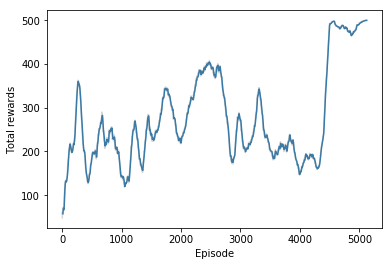

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

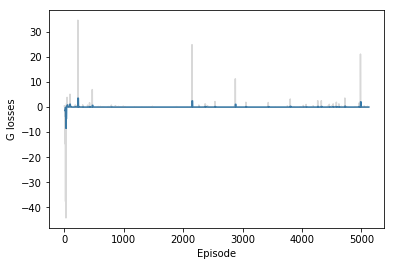

In [53]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

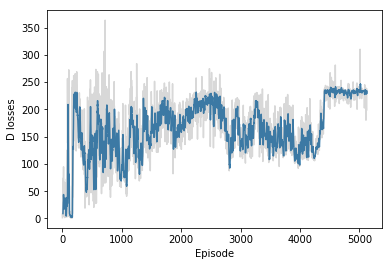

In [54]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

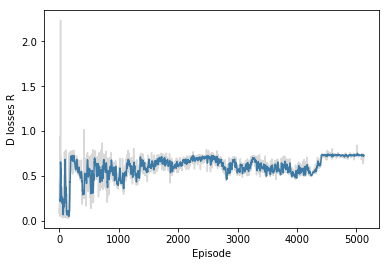

In [58]:
eps, arr = np.array(d_lossQsigm_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

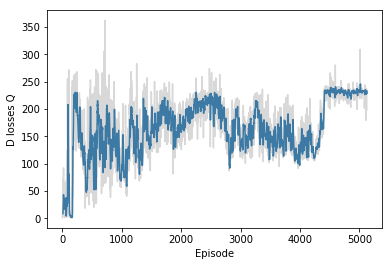

In [59]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [ ]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)

        # Training steps/batches
        while True:
            # Testing/inference
            env.render()
            action_logits, g_initial_state, d_initial_state = sess.run(
                fetches=[model.actions_logits, model.g_final_state, model.d_final_state], 
                feed_dict={model.states: np.reshape(state, [1, -1]),
                           model.g_initial_state: g_initial_state, 
                           model.d_initial_state: d_initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
# Closing the env
print('total_reward: {}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.